# Fine-Tuning HuBERT-Large for Dysarthric Voice Command Classification

This notebook fine-tunes a pretrained HuBERT-large model on the TORGO dataset for recognizing dysarthric voice commands.

## Why HuBERT?

**HuBERT (Hidden-Unit BERT)** is chosen for several reasons:
1. **Self-supervised pretraining**: Trained on 960h of LibriSpeech, learning robust speech representations
2. **Masked prediction objective**: Similar to BERT, learns contextual representations useful for downstream tasks
3. **State-of-the-art performance**: Competitive with wav2vec 2.0 on speech recognition benchmarks
4. **Transfer learning**: Pretrained features transfer well to low-resource speech tasks like dysarthric speech

## Target Commands (from TORGO)
- **Digits**: zero through nine (10 classes)
- **Directional/Control**: yes, no, up, down, left, right, forward, back, select, menu (10 classes)  
- **NATO Radio Alphabet**: alpha through zulu (26 classes)

These commands are specifically designed for accessibility software, making them ideal for dysarthric voice command recognition.

## 1. Setup and Dependencies

In [ ]:
# Install dependencies (run once)
# !pip install -r ./requirements.txt

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================
# Standard library
import os
import json
import random
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Audio processing
# NOTE: Using librosa instead of torchaudio because torchaudio's default backend
# requires torchcodec + FFmpeg which can be problematic to install
import librosa

# Audio augmentation
# audiomentations provides industry-standard audio augmentations
# See: https://github.com/iver56/audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Model loading
# NOTE: Using HuggingFace transformers for model architecture, but downloading
# weights from ModelScope (Chinese mirror) for accessibility in China
from transformers import HubertModel, Wav2Vec2FeatureExtractor
from modelscope import snapshot_download

# =============================================================================
# REPRODUCIBILITY
# =============================================================================
def set_seed(seed: int = 42):
    """
    Set random seeds for reproducibility across Python, NumPy, and PyTorch.
    
    Note: For full reproducibility with CUDA, you may also need:
    - torch.backends.cudnn.deterministic = True
    - torch.backends.cudnn.benchmark = False
    But this can significantly slow down training.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# =============================================================================
# DEVICE CONFIGURATION
# =============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

/root/miniconda3/envs/voice-cmd/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce RTX 5090
GPU Memory: 33.7 GB


In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================
class Config:
    """
    Centralized configuration for the dysarthric voice command classifier.
    
    Design decisions documented inline.
    """
    
    # -------------------------------------------------------------------------
    # PATHS
    # -------------------------------------------------------------------------
    TORGO_ROOT = Path("/root/autodl-tmp/TORGO")
    OUTPUT_DIR = Path("/root/autodl-tmp/dysarthric-voice-cmds/outputs")
    MODEL_CACHE_DIR = Path("/root/autodl-tmp/dysarthric-voice-cmds/model_cache")
    
    # -------------------------------------------------------------------------
    # TARGET COMMANDS
    # -------------------------------------------------------------------------
    # These are from TORGO's "short words" category, specifically designed for
    # assistive technology / accessibility software (see TORGO documentation)
    DIGITS = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
    COMMANDS = ['yes', 'no', 'up', 'down', 'left', 'right', 'forward', 'back', 'select', 'menu']
    RADIO_ALPHABET = [
        'alpha', 'bravo', 'charlie', 'delta', 'echo', 'foxtrot', 'golf', 'hotel',
        'india', 'juliet', 'kilo', 'lima', 'mike', 'november', 'oscar', 'papa',
        'quebec', 'romeo', 'sierra', 'tango', 'uniform', 'victor', 'whiskey',
        'xray', 'yankee', 'zulu'
    ]
    # SCALE UP: 20 classes (digits + directional commands)
    # Change to DIGITS + COMMANDS + RADIO_ALPHABET for full 46 classes
    TARGET_COMMANDS = DIGITS + COMMANDS  # 20 classes
    
    # -------------------------------------------------------------------------
    # AUDIO SETTINGS
    # -------------------------------------------------------------------------
    # HuBERT was trained on 16kHz audio - must match for optimal performance
    SAMPLE_RATE = 16000
    
    # Max audio length: Single-word commands are typically <2 seconds.
    # 3 seconds provides buffer for slower dysarthric speech.
    # Trade-off: Longer = more memory, shorter = potential truncation
    MAX_AUDIO_LENGTH = 3.0  # seconds
    MAX_AUDIO_SAMPLES = int(SAMPLE_RATE * MAX_AUDIO_LENGTH)  # 48000 samples
    
    # -------------------------------------------------------------------------
    # MODEL SETTINGS
    # -------------------------------------------------------------------------
    # HuBERT-large: 24 transformer layers, 1024 hidden size, 315M params
    # Why large vs base? Better representations, but slower/more memory
    # For production, consider HuBERT-base (90M params) with slight accuracy trade-off
    MODELSCOPE_MODEL_ID = "facebook/hubert-large-ls960-ft"
    HIDDEN_SIZE = 1024  # Must match HuBERT-large architecture
    
    # Classifier settings
    CLASSIFIER_DROPOUT = 0.1  # Standard dropout for regularization
    
    # -------------------------------------------------------------------------
    # TRAINING SETTINGS
    # -------------------------------------------------------------------------
    # Batch size: Limited by GPU memory with 315M param model
    # RTX 4090 (24GB) can handle 8-16; reduce for smaller GPUs
    BATCH_SIZE = 8
    
    # Learning rates: Following transfer learning best practices
    # - Higher LR (1e-4) for randomly initialized classifier head
    # - Lower LR (1e-5) for pretrained encoder to avoid catastrophic forgetting
    LEARNING_RATE = 1e-4          # For classifier head (warmup phase)
    LEARNING_RATE_FINETUNE = 1e-5  # For encoder fine-tuning
    
    # Epochs: Two-phase training strategy
    # Phase 1 (warmup): Train only classifier, encoder frozen
    # Phase 2 (finetune): Unfreeze top encoder layers, lower LR
    NUM_EPOCHS = 20
    WARMUP_EPOCHS = 5
    
    # Number of top transformer layers to unfreeze in Phase 2
    # Why 4? Trade-off between adaptation and preserving pretrained knowledge
    # More layers = more adaptation but higher overfitting risk on small data
    UNFREEZE_LAYERS = 4
    
    # Gradient clipping to prevent exploding gradients during fine-tuning
    MAX_GRAD_NORM = 1.0
    
    # Weight decay for AdamW optimizer (L2 regularization)
    WEIGHT_DECAY = 0.01
    
    # -------------------------------------------------------------------------
    # DATA SETTINGS
    # -------------------------------------------------------------------------
    # TORGO has two microphone types:
    # - wav_arrayMic: Acoustic Magic array microphone (better quality, recommended)
    # - wav_headMic: Head-mounted microphone (more noise from EMA interference)
    MIC_TYPE = "wav_arrayMic"
    
    # Whether to use class-weighted loss for imbalanced classes
    # IMPORTANT: Set to True when classes have very different sample counts
    # Uses "balanced" strategy: weight = n_samples / (n_classes * n_samples_for_class)
    USE_CLASS_WEIGHTS = True
    
    # -------------------------------------------------------------------------
    # AUGMENTATION SETTINGS
    # -------------------------------------------------------------------------
    # audiomentations-based augmentation pipeline (industry standard)
    # Each augmentation has a probability (p) of being applied
    
    # Time-domain augmentations
    AUG_NOISE_MIN_AMP = 0.001    # Minimum Gaussian noise amplitude
    AUG_NOISE_MAX_AMP = 0.015    # Maximum Gaussian noise amplitude
    AUG_NOISE_PROB = 0.5         # Probability of adding noise
    
    AUG_PITCH_MIN_SEMITONES = -2  # Min pitch shift (semitones)
    AUG_PITCH_MAX_SEMITONES = 2   # Max pitch shift (semitones)
    AUG_PITCH_PROB = 0.5          # Probability of pitch shift
    
    AUG_TIMESTRETCH_MIN = 0.9     # Min time stretch factor
    AUG_TIMESTRETCH_MAX = 1.1     # Max time stretch factor
    AUG_TIMESTRETCH_PROB = 0.5    # Probability of time stretch
    
    AUG_SHIFT_MIN = -0.2          # Min shift as fraction of total length
    AUG_SHIFT_MAX = 0.2           # Max shift as fraction of total length
    AUG_SHIFT_PROB = 0.3          # Probability of time shift
    
    AUG_GAIN_MIN_DB = -6          # Min gain adjustment (dB)
    AUG_GAIN_MAX_DB = 6           # Max gain adjustment (dB)
    AUG_GAIN_PROB = 0.5           # Probability of gain adjustment
    
    # SpecAugment settings (frequency/time masking)
    # From Google's SpecAugment paper (Park et al., 2019)
    SPEC_AUG_FREQ_MASK_PARAM = 27  # Max frequency bands to mask (F)
    SPEC_AUG_TIME_MASK_PARAM = 100 # Max time steps to mask (T)
    SPEC_AUG_NUM_FREQ_MASKS = 1    # Number of frequency masks
    SPEC_AUG_NUM_TIME_MASKS = 1    # Number of time masks
    
    # -------------------------------------------------------------------------
    # CURRICULUM LEARNING SETTINGS
    # -------------------------------------------------------------------------
    # Three-phase curriculum learning approach:
    # Phase A: Train on control speakers (clean speech, closer to HuBERT pretraining)
    # Phase B: Fine-tune on dysarthric speakers only (adapt to dysarthric patterns)
    # Phase C: LOSO evaluation on dysarthric speakers
    
    CURRICULUM_CONTROL_EPOCHS = 15    # Phase A: epochs on control speakers
    CURRICULUM_DYSARTHRIC_EPOCHS = 15  # Phase B: epochs on dysarthric speakers
    CURRICULUM_UNFREEZE_LAYERS = 4     # Layers to unfreeze during fine-tuning
    
    # Phase A learning rates (control pretraining)
    CURRICULUM_CONTROL_LR = 1e-4           # Higher LR for classifier warmup
    CURRICULUM_CONTROL_LR_FINETUNE = 1e-5  # Lower LR when unfreezing encoder
    
    # Phase B learning rates (dysarthric fine-tuning)
    CURRICULUM_DYSARTHRIC_LR = 5e-5        # Lower LR to preserve control knowledge
    CURRICULUM_DYSARTHRIC_LR_ENCODER = 5e-6  # Even lower for encoder

config = Config()

# Create output directories
config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
config.MODEL_CACHE_DIR.mkdir(parents=True, exist_ok=True)

print(f"Target commands ({len(config.TARGET_COMMANDS)} classes):")
print(f"  Digits: {config.DIGITS}")
print(f"  Commands: {config.COMMANDS}")
print(f"  Radio alphabet: {config.RADIO_ALPHABET}")

Target commands (20 classes):
  Digits: ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
  Commands: ['yes', 'no', 'up', 'down', 'left', 'right', 'forward', 'back', 'select', 'menu']
  Radio alphabet: ['alpha', 'bravo', 'charlie', 'delta', 'echo', 'foxtrot', 'golf', 'hotel', 'india', 'juliet', 'kilo', 'lima', 'mike', 'november', 'oscar', 'papa', 'quebec', 'romeo', 'sierra', 'tango', 'uniform', 'victor', 'whiskey', 'xray', 'yankee', 'zulu']


## 2. Data Preprocessing

### TORGO Dataset Structure
The TORGO dataset is organized as:
```
TORGO/
├── F/          # Female dysarthric speakers (F01, F03, F04)
├── FC/         # Female control speakers (FC01, FC02, FC03)
├── M/          # Male dysarthric speakers (M01-M05)
└── MC/         # Male control speakers (MC01-MC04)
    └── {SpeakerID}/
        └── Session{N}/
            ├── prompts/     # Text files with spoken content
            ├── wav_arrayMic/ # Array microphone recordings (16kHz)
            └── wav_headMic/  # Head-mounted mic recordings (noisier)
```

### Why Speaker-Independent Splits?
We split by **speaker** rather than randomly because:
1. Same speaker's samples are highly correlated (voice characteristics)
2. Random splits would leak speaker identity, inflating metrics
3. Real-world use requires generalizing to unseen speakers

In [3]:
def parse_speaker_info(speaker_id: str) -> Tuple[str, bool]:
    """
    Parse speaker ID to extract gender and dysarthria status.
    
    Speaker ID format:
    - F01, F03, F04: Female dysarthric
    - FC01, FC02, FC03: Female control (no dysarthria)
    - M01-M05: Male dysarthric
    - MC01-MC04: Male control (no dysarthria)
    """
    is_dysarthric = 'C' not in speaker_id
    gender = 'F' if speaker_id.startswith('F') else 'M'
    return gender, is_dysarthric


def scan_torgo_dataset(torgo_root: Path, target_commands: List[str], mic_type: str = "wav_arrayMic") -> pd.DataFrame:
    """
    Scan TORGO dataset and extract samples matching target command words.
    
    Returns DataFrame with columns: file_path, speaker_id, session, utterance_id, 
                                    label, gender, is_dysarthric
    """
    samples = []
    target_commands_lower = [cmd.lower() for cmd in target_commands]
    
    # Scan each speaker folder (F, FC, M, MC)
    for group_dir in torgo_root.iterdir():
        if not group_dir.is_dir() or group_dir.name.startswith('.'):
            continue
            
        # Scan each speaker in the group
        for speaker_dir in group_dir.iterdir():
            if not speaker_dir.is_dir():
                continue
                
            speaker_id = speaker_dir.name
            gender, is_dysarthric = parse_speaker_info(speaker_id)
            
            # Scan each session
            for session_dir in speaker_dir.iterdir():
                if not session_dir.is_dir() or not session_dir.name.startswith('Session'):
                    continue
                    
                session = session_dir.name
                prompts_dir = session_dir / "prompts"
                wav_dir = session_dir / mic_type
                
                if not prompts_dir.exists() or not wav_dir.exists():
                    continue
                
                # Scan each prompt file
                for prompt_file in prompts_dir.glob("*.txt"):
                    utterance_id = prompt_file.stem
                    wav_file = wav_dir / f"{utterance_id}.wav"
                    
                    if not wav_file.exists():
                        continue
                    
                    # Read and normalize the prompt
                    try:
                        prompt_text = prompt_file.read_text().strip().lower()
                    except:
                        continue
                    
                    # Check if it matches a target command (exact match only)
                    # Some prompts have annotations like "read [as in I can read]"
                    # Extract just the first word for matching
                    first_word = prompt_text.split()[0] if prompt_text else ""
                    
                    if first_word in target_commands_lower:
                        samples.append({
                            'file_path': str(wav_file),
                            'speaker_id': speaker_id,
                            'session': session,
                            'utterance_id': utterance_id,
                            'label': first_word,
                            'gender': gender,
                            'is_dysarthric': is_dysarthric
                        })
    
    df = pd.DataFrame(samples)
    return df


# Scan the dataset
print("Scanning TORGO dataset...")
df = scan_torgo_dataset(config.TORGO_ROOT, config.TARGET_COMMANDS, config.MIC_TYPE)

print(f"\nFound {len(df)} samples matching target commands")
print(f"Unique speakers: {df['speaker_id'].nunique()}")
print(f"Unique labels: {df['label'].nunique()}")

Scanning TORGO dataset...

Found 562 samples matching target commands
Unique speakers: 15
Unique labels: 20


In [4]:
# Explore the dataset
print("Dataset overview:")
print(df.head(10))
print("\n" + "="*60)

print("\nSamples per speaker:")
speaker_counts = df.groupby(['speaker_id', 'is_dysarthric']).size().reset_index(name='count')
print(speaker_counts.to_string(index=False))

print("\n" + "="*60)
print("\nSamples per command (top 20):")
label_counts = df['label'].value_counts()
print(label_counts.head(20))

print("\n" + "="*60)
print(f"\nDysarthric samples: {df[df['is_dysarthric']].shape[0]}")
print(f"Control samples: {df[~df['is_dysarthric']].shape[0]}")

Dataset overview:
                                           file_path speaker_id   session  \
0  /root/autodl-tmp/TORGO/F/F01/Session1/wav_arra...        F01  Session1   
1  /root/autodl-tmp/TORGO/F/F01/Session1/wav_arra...        F01  Session1   
2  /root/autodl-tmp/TORGO/F/F01/Session1/wav_arra...        F01  Session1   
3  /root/autodl-tmp/TORGO/F/F01/Session1/wav_arra...        F01  Session1   
4  /root/autodl-tmp/TORGO/F/F01/Session1/wav_arra...        F01  Session1   
5  /root/autodl-tmp/TORGO/F/F01/Session1/wav_arra...        F01  Session1   
6  /root/autodl-tmp/TORGO/F/F01/Session1/wav_arra...        F01  Session1   
7  /root/autodl-tmp/TORGO/F/F01/Session1/wav_arra...        F01  Session1   
8  /root/autodl-tmp/TORGO/F/F03/Session1/wav_arra...        F03  Session1   
9  /root/autodl-tmp/TORGO/F/F03/Session1/wav_arra...        F03  Session1   

  utterance_id  label gender  is_dysarthric  
0         0010     up      F           True  
1         0088   left      F           Tru

In [5]:
# Create label encoding
labels_in_dataset = sorted(df['label'].unique())
label2id = {label: idx for idx, label in enumerate(labels_in_dataset)}
id2label = {idx: label for label, idx in label2id.items()}

df['label_id'] = df['label'].map(label2id)

print(f"Number of classes: {len(label2id)}")
print(f"\nLabel mapping:")
for label, idx in sorted(label2id.items(), key=lambda x: x[1]):
    count = (df['label'] == label).sum()
    print(f"  {idx:2d}: {label:12s} ({count} samples)")

# Save label mapping
label_mapping = {'label2id': label2id, 'id2label': id2label}
with open(config.OUTPUT_DIR / 'label_mapping.json', 'w') as f:
    json.dump(label_mapping, f, indent=2)
print(f"\nLabel mapping saved to {config.OUTPUT_DIR / 'label_mapping.json'}")

Number of classes: 20

Label mapping:
   0: back         (20 samples)
   1: down         (23 samples)
   2: eight        (22 samples)
   3: five         (22 samples)
   4: forward      (18 samples)
   5: four         (31 samples)
   6: left         (28 samples)
   7: menu         (18 samples)
   8: nine         (21 samples)
   9: no           (53 samples)
  10: one          (41 samples)
  11: right        (24 samples)
  12: select       (19 samples)
  13: seven        (23 samples)
  14: six          (28 samples)
  15: three        (24 samples)
  16: two          (47 samples)
  17: up           (25 samples)
  18: yes          (53 samples)
  19: zero         (22 samples)

Label mapping saved to /root/autodl-tmp/dysarthric-voice-cmds/outputs/label_mapping.json


In [6]:
# Create speaker-independent train/val/test splits
# This ensures the model is evaluated on unseen speakers

def create_speaker_splits(df: pd.DataFrame, val_speakers: List[str], test_speakers: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split dataset by speakers for proper evaluation.
    """
    train_df = df[~df['speaker_id'].isin(val_speakers + test_speakers)].copy()
    val_df = df[df['speaker_id'].isin(val_speakers)].copy()
    test_df = df[df['speaker_id'].isin(test_speakers)].copy()
    
    return train_df, val_df, test_df

# Get available speakers
available_speakers = df['speaker_id'].unique().tolist()
print(f"Available speakers: {available_speakers}")

# Define splits based on available speakers
# We'll use a simple heuristic: last speaker of each group for val/test
dysarthric_speakers = df[df['is_dysarthric']]['speaker_id'].unique().tolist()
control_speakers = df[~df['is_dysarthric']]['speaker_id'].unique().tolist()

print(f"Dysarthric speakers: {dysarthric_speakers}")
print(f"Control speakers: {control_speakers}")

# Assign splits (adjust based on what's available)
# For now, we'll do a simple split - you can adjust as more data becomes available
if len(dysarthric_speakers) >= 2:
    val_speakers = [dysarthric_speakers[-1]]  # Last dysarthric speaker for validation
else:
    val_speakers = []
    
if len(control_speakers) >= 1:
    val_speakers.extend([control_speakers[-1]])  # Last control speaker for validation

# For test, we'll hold out from training set (can be adjusted later)
test_speakers = []  # Will add when more speakers are available

print(f"\nValidation speakers: {val_speakers}")
print(f"Test speakers: {test_speakers}")

train_df, val_df, test_df = create_speaker_splits(df, val_speakers, test_speakers)

print(f"\nSplit sizes:")
print(f"  Train: {len(train_df)} samples from {train_df['speaker_id'].nunique()} speakers")
print(f"  Val:   {len(val_df)} samples from {val_df['speaker_id'].nunique()} speakers")
print(f"  Test:  {len(test_df)} samples from {test_df['speaker_id'].nunique()} speakers")

# Save the splits
train_df.to_csv(config.OUTPUT_DIR / 'train.csv', index=False)
val_df.to_csv(config.OUTPUT_DIR / 'val.csv', index=False)
if len(test_df) > 0:
    test_df.to_csv(config.OUTPUT_DIR / 'test.csv', index=False)
print(f"\nSplits saved to {config.OUTPUT_DIR}")

Available speakers: ['F01', 'F03', 'F04', 'FC01', 'FC02', 'FC03', 'M01', 'M02', 'M03', 'M04', 'M05', 'MC01', 'MC02', 'MC03', 'MC04']
Dysarthric speakers: ['F01', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04', 'M05']
Control speakers: ['FC01', 'FC02', 'FC03', 'MC01', 'MC02', 'MC03', 'MC04']

Validation speakers: ['M05', 'MC04']
Test speakers: []

Split sizes:
  Train: 491 samples from 13 speakers
  Val:   71 samples from 2 speakers
  Test:  0 samples from 0 speakers

Splits saved to /root/autodl-tmp/dysarthric-voice-cmds/outputs


## 3. Dataset Class

### Audio Preprocessing Pipeline
1. **Load audio** with librosa (handles various formats, automatic resampling)
2. **Resample** to 16kHz (HuBERT's expected input)
3. **Pad/Truncate** to fixed length (3 seconds = 48000 samples)
4. **Augmentation** (training only): comprehensive pipeline via audiomentations
5. **Feature extraction** via Wav2Vec2FeatureExtractor (normalization)

### Data Augmentation Strategy (Industry Standard)

Using **audiomentations** library for comprehensive augmentation:

| Augmentation | Effect | Why Important for Dysarthria |
|--------------|--------|------------------------------|
| AddGaussianNoise | Simulates background noise | Robustness to recording conditions |
| PitchShift | Varies voice pitch | Handles pitch variability in dysarthric speech |
| TimeStretch | Varies speaking rate | Critical: dysarthric speakers often have varied tempo |
| Shift | Shifts audio in time | Handles recording start/end variations |
| Gain | Adjusts volume | Microphone distance variations |
| SpecAugment (time mask) | Masks time segments | Regularization, prevents overfitting |

### Design Decisions
- **Fixed-length inputs**: Simplifies batching; 3 seconds is sufficient for single-word commands
- **Center-crop truncation**: Command is likely in the middle of longer recordings
- **Zero-padding**: Silence doesn't affect the command classification
- **librosa over torchaudio**: Avoids FFmpeg/torchcodec dependency issues
- **Augmentation before final pad**: Time stretch can change length, so we re-pad after

In [7]:
def create_augmentation_pipeline(config) -> Compose:
    """
    Create audiomentations augmentation pipeline based on config settings.
    
    Industry-standard augmentations for speech:
    1. AddGaussianNoise: Simulates microphone noise, room acoustics
    2. PitchShift: Simulates voice pitch variations
    3. TimeStretch: Simulates speaking rate variations (important for dysarthria!)
    4. Shift: Simulates different recording start/end times
    5. Gain: Simulates microphone distance variations
    
    References:
    - SpecAugment paper (Park et al., 2019) for masking techniques
    - Kaldi/ESPnet for speech perturbation practices
    """
    return Compose([
        AddGaussianNoise(
            min_amplitude=config.AUG_NOISE_MIN_AMP,
            max_amplitude=config.AUG_NOISE_MAX_AMP,
            p=config.AUG_NOISE_PROB
        ),
        PitchShift(
            min_semitones=config.AUG_PITCH_MIN_SEMITONES,
            max_semitones=config.AUG_PITCH_MAX_SEMITONES,
            p=config.AUG_PITCH_PROB
        ),
        TimeStretch(
            min_rate=config.AUG_TIMESTRETCH_MIN,
            max_rate=config.AUG_TIMESTRETCH_MAX,
            p=config.AUG_TIMESTRETCH_PROB
        ),
        Shift(
            min_shift=config.AUG_SHIFT_MIN,
            max_shift=config.AUG_SHIFT_MAX,
            p=config.AUG_SHIFT_PROB
        ),
        Gain(
            min_gain_db=config.AUG_GAIN_MIN_DB,
            max_gain_db=config.AUG_GAIN_MAX_DB,
            p=config.AUG_GAIN_PROB
        ),
    ])


def apply_spec_augment(spectrogram: np.ndarray, config) -> np.ndarray:
    """
    Apply SpecAugment-style masking directly to waveform-derived features.
    
    Note: True SpecAugment operates on spectrograms, but HuBERT processes
    raw waveforms. This is a simplified version that masks time segments
    of the waveform, which has similar regularization effects.
    
    For proper SpecAugment, you would apply masking to mel-spectrograms
    before feeding to an acoustic model. Since HuBERT has its own internal
    feature extraction, we apply time-domain masking as an approximation.
    
    Args:
        spectrogram: Audio waveform (we're masking time segments)
        config: Config with SPEC_AUG parameters
        
    Returns:
        Masked waveform
    """
    waveform = spectrogram.copy()
    length = len(waveform)
    
    # Time masking: zero out random contiguous segments
    for _ in range(config.SPEC_AUG_NUM_TIME_MASKS):
        t = random.randint(0, min(config.SPEC_AUG_TIME_MASK_PARAM, length // 10))
        t0 = random.randint(0, max(0, length - t))
        waveform[t0:t0 + t] = 0
    
    return waveform


class TORGOCommandDataset(Dataset):
    """
    PyTorch Dataset for TORGO dysarthric voice commands with advanced augmentation.
    
    Handles audio loading, preprocessing, and augmentation for HuBERT input.
    
    Augmentation Pipeline (training only):
    --------------------------------------
    1. audiomentations: Noise, pitch shift, time stretch, shift, gain
    2. SpecAugment: Time masking (frequency masking N/A for waveforms)
    
    Design Decisions:
    -----------------
    1. Uses librosa for audio loading (avoids torchaudio's FFmpeg dependency)
    2. Fixed-length outputs via padding/truncation (simplifies batching)
    3. Center-crop for truncation (command likely in middle of recording)
    4. Industry-standard augmentation via audiomentations library
    
    Args:
        df: DataFrame with columns ['file_path', 'label_id', 'speaker_id', ...]
        feature_extractor: HuggingFace Wav2Vec2FeatureExtractor for normalization
        config: Config object with augmentation parameters
        max_length: Maximum audio length in samples (default: 48000 = 3s at 16kHz)
        target_sr: Target sample rate (must be 16000 for HuBERT)
        augment: Whether to apply data augmentation (True for training)
    """
    
    def __init__(
        self,
        df: pd.DataFrame,
        feature_extractor: Wav2Vec2FeatureExtractor,
        config,
        max_length: int = 48000,
        target_sr: int = 16000,
        augment: bool = False
    ):
        self.df = df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.config = config
        self.max_length = max_length
        self.target_sr = target_sr
        self.augment = augment
        
        # Create augmentation pipeline if training
        if augment:
            self.augmentation_pipeline = create_augmentation_pipeline(config)
        else:
            self.augmentation_pipeline = None
        
    def __len__(self) -> int:
        return len(self.df)
    
    def load_audio(self, file_path: str) -> np.ndarray:
        """
        Load audio file and resample to target sample rate.
        
        Uses librosa which:
        - Automatically resamples to target_sr
        - Converts stereo to mono
        - Handles various audio formats
        
        Returns silence (zeros) on error to avoid crashing the training loop.
        """
        try:
            audio, _ = librosa.load(file_path, sr=self.target_sr, mono=True)
            return audio
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return np.zeros(self.max_length, dtype=np.float32)
    
    def pad_or_truncate(self, audio: np.ndarray) -> np.ndarray:
        """
        Ensure audio is exactly max_length samples.
        
        Truncation: Center-crop (assumes command is in the middle)
        Padding: Zero-pad at the end (silence doesn't affect classification)
        
        Alternative strategies (not used):
        - Random crop for truncation (good for augmentation)
        - Repeat-pad instead of zero-pad (maintains energy)
        """
        if len(audio) > self.max_length:
            # Center crop: command is likely in the middle
            start = (len(audio) - self.max_length) // 2
            audio = audio[start:start + self.max_length]
        elif len(audio) < self.max_length:
            # Zero-pad at end
            padding = self.max_length - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')
        return audio
    
    def apply_augmentation(self, audio: np.ndarray) -> np.ndarray:
        """
        Apply comprehensive data augmentation pipeline.
        
        Augmentation stages:
        1. audiomentations pipeline: noise, pitch, time stretch, shift, gain
        2. SpecAugment-style time masking: zeros out random time segments
        
        This provides strong regularization for small datasets and helps
        the model generalize to unseen speakers and recording conditions.
        """
        if not self.augment or self.augmentation_pipeline is None:
            return audio
        
        # Stage 1: audiomentations (operates on numpy array)
        # audiomentations expects float32 audio in range [-1, 1]
        audio = audio.astype(np.float32)
        audio = self.augmentation_pipeline(samples=audio, sample_rate=self.target_sr)
        
        # Stage 2: SpecAugment-style time masking (50% probability)
        if random.random() < 0.5:
            audio = apply_spec_augment(audio, self.config)
        
        return audio
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        row = self.df.iloc[idx]
        
        # Load audio
        audio = self.load_audio(row['file_path'])
        
        # Pad or truncate BEFORE augmentation
        # (time stretch can change length, so we normalize after)
        audio = self.pad_or_truncate(audio)
        
        # Apply augmentation (training only)
        audio = self.apply_augmentation(audio)
        
        # Re-pad/truncate in case augmentation changed length
        audio = self.pad_or_truncate(audio)
        
        # Process with feature extractor
        inputs = self.feature_extractor(
            audio,
            sampling_rate=self.target_sr,
            return_tensors="pt",
            padding=False
        )
        
        # Remove batch dimension added by feature extractor
        input_values = inputs.input_values.squeeze(0)
        
        return {
            'input_values': input_values,
            'label': torch.tensor(row['label_id'], dtype=torch.long),
            'speaker_id': row['speaker_id'],
            'file_path': row['file_path']
        }


def collate_fn(batch: List[Dict]) -> Dict[str, torch.Tensor]:
    """Custom collate function for DataLoader."""
    input_values = torch.stack([item['input_values'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    
    return {
        'input_values': input_values,
        'labels': labels,
        'speaker_ids': [item['speaker_id'] for item in batch],
        'file_paths': [item['file_path'] for item in batch]
    }

In [8]:
# Download model from ModelScope and create feature extractor
print("Downloading HuBERT-large from ModelScope...")
model_dir = snapshot_download(
    config.MODELSCOPE_MODEL_ID, 
    cache_dir=str(config.MODEL_CACHE_DIR)
)
print(f"Model downloaded to: {model_dir}")

# Load feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_dir)
print("Feature extractor loaded successfully")

Model downloaded to: /root/autodl-tmp/dysarthric-voice-cmds/model_cache/facebook/hubert-large-ls960-ft
Feature extractor loaded successfully


In [9]:
# Create datasets (now with config for augmentation parameters)
train_dataset = TORGOCommandDataset(
    train_df, 
    feature_extractor,
    config=config,
    max_length=config.MAX_AUDIO_SAMPLES,
    augment=True  # Enable augmentation for training
)

val_dataset = TORGOCommandDataset(
    val_df, 
    feature_extractor,
    config=config,
    max_length=config.MAX_AUDIO_SAMPLES,
    augment=False
)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

# =============================================================================
# CLASS WEIGHTS FOR IMBALANCED DATA
# =============================================================================
# Compute class weights to handle class imbalance
# Uses sklearn's "balanced" strategy: weight = n_samples / (n_classes * n_samples_for_class)
# This gives higher weight to minority classes, preventing the model from
# ignoring rare commands like "romeo" (2 samples) vs "no" (20 samples)

if config.USE_CLASS_WEIGHTS:
    train_labels = train_df['label_id'].values
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    print(f"\nClass weights computed (balanced strategy)")
    print(f"  Min weight: {class_weights.min().item():.3f}")
    print(f"  Max weight: {class_weights.max().item():.3f}")
    print(f"  Weight ratio (max/min): {class_weights.max().item() / class_weights.min().item():.1f}x")
else:
    class_weights = None
    print("\nClass weights: disabled")

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True
)

# Test loading a batch
print("\nTesting dataloader...")
batch = next(iter(train_loader))
print(f"Input values shape: {batch['input_values'].shape}")
print(f"Labels shape: {batch['labels'].shape}")
print(f"Sample labels: {[id2label[l.item()] for l in batch['labels']]}")

Train dataset: 491 samples
Val dataset: 71 samples

Class weights computed (balanced strategy)
  Min weight: 0.522
  Max weight: 1.534
  Weight ratio (max/min): 2.9x

Testing dataloader...
Input values shape: torch.Size([8, 48000])
Labels shape: torch.Size([8])
Sample labels: ['four', 'left', 'no', 'one', 'no', 'yes', 'zero', 'no']


## 4. Model Definition

### Architecture
```
Audio Waveform → HuBERT Encoder → Attention Pooling → MLP Classifier → Class Logits
     (48000)        (150, 1024)        (1024)         (1024→512→20)
```

### Why This Architecture?

1. **HuBERT Encoder**: Pretrained self-supervised speech model
   - Captures acoustic and linguistic features
   - 24 transformer layers, 1024 hidden size

2. **Attention Pooling**: Learns which frames are important for classification
   - Unlike mean pooling, doesn't treat all frames equally
   - Can focus on discriminative phonemes (e.g., the "t" in "two" vs "w" in "one")
   - Trainable: adds ~263K parameters to learn attention weights

3. **MLP Classifier** (2-layer): More capacity than single linear layer
   - Hidden layer (512) with GELU activation
   - Dropout for regularization

### Freezing Strategy

Why freeze encoder initially?
- Pretrained weights are already good feature extractors
- Training only attention pooling + classifier first
- Faster training, less overfitting risk on small data
- Gradual unfreezing prevents catastrophic forgetting

In [10]:
class AttentionPooling(nn.Module):
    """
    Attention-based pooling layer that learns which frames are important.
    
    Instead of mean pooling (treating all frames equally), this learns
    attention weights to focus on discriminative frames. This is crucial
    for speech classification where the relevant phonemes are concentrated
    in specific parts of the audio.
    """
    def __init__(self, hidden_size: int):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 4),  # 1024 -> 256
            nn.Tanh(),
            nn.Linear(hidden_size // 4, 1)  # 256 -> 1 (attention score per frame)
        )
    
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        """
        Apply attention pooling.
        
        Args:
            hidden_states: (batch, seq_len, hidden_size)
            
        Returns:
            pooled: (batch, hidden_size)
        """
        # Compute attention scores for each frame
        attention_scores = self.attention(hidden_states)  # (batch, seq_len, 1)
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch, seq_len, 1)
        
        # Weighted sum of hidden states
        pooled = (hidden_states * attention_weights).sum(dim=1)  # (batch, hidden_size)
        
        return pooled


class HuBERTForCommandClassification(nn.Module):
    """
    HuBERT model with a classification head for voice command recognition.
    
    Architecture:
    - HuBERT encoder (frozen initially, then fine-tuned)
    - Attention pooling over time dimension (learns which frames matter)
    - MLP classifier
    """
    
    def __init__(
        self,
        model_path: str,
        num_labels: int,
        hidden_size: int = 1024,
        classifier_dropout: float = 0.1,
        freeze_encoder: bool = True,
        freeze_feature_extractor: bool = True
    ):
        super().__init__()
        
        # Load pretrained HuBERT encoder
        self.hubert = HubertModel.from_pretrained(model_path)
        self.hidden_size = hidden_size
        self.num_labels = num_labels
        
        # Attention pooling instead of mean pooling
        # This learns which frames are important for classification
        self.attention_pooling = AttentionPooling(hidden_size)
        
        # Classification head (MLP instead of single linear layer)
        # MLP provides more capacity to learn complex decision boundaries
        # Architecture: hidden_size -> hidden_size//2 -> num_labels
        classifier_hidden = hidden_size // 2  # 512 for HuBERT-large
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, classifier_hidden),
            nn.GELU(),  # GELU activation (same as HuBERT/BERT internals)
            nn.Dropout(classifier_dropout),
            nn.Linear(classifier_hidden, num_labels)
        )
        
        # Freeze encoder if specified
        if freeze_encoder:
            self.freeze_encoder()
        
        # Always freeze feature extractor initially (CNN layers)
        if freeze_feature_extractor:
            self.freeze_feature_extractor()
    
    def freeze_encoder(self):
        """Freeze all HuBERT encoder parameters."""
        for param in self.hubert.parameters():
            param.requires_grad = False
        print("HuBERT encoder frozen")
    
    def unfreeze_encoder(self, num_layers: Optional[int] = None):
        """
        Unfreeze HuBERT encoder parameters.
        
        Args:
            num_layers: If specified, only unfreeze the top N transformer layers.
                       If None, unfreeze all encoder layers (but not feature extractor).
        """
        if num_layers is None:
            # Unfreeze all encoder layers
            for param in self.hubert.encoder.parameters():
                param.requires_grad = True
            print("All HuBERT encoder layers unfrozen")
        else:
            # Unfreeze only top N layers
            total_layers = len(self.hubert.encoder.layers)
            for i, layer in enumerate(self.hubert.encoder.layers):
                if i >= total_layers - num_layers:
                    for param in layer.parameters():
                        param.requires_grad = True
            print(f"Top {num_layers} HuBERT encoder layers unfrozen")
    
    def freeze_feature_extractor(self):
        """Freeze the CNN feature extractor (always recommended)."""
        for param in self.hubert.feature_extractor.parameters():
            param.requires_grad = False
        for param in self.hubert.feature_projection.parameters():
            param.requires_grad = False
        print("HuBERT feature extractor frozen")
    
    def forward(
        self,
        input_values: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        class_weights: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:
        """
        Forward pass.
        
        Args:
            input_values: (batch, seq_len) raw audio waveform
            attention_mask: (batch, seq_len) optional attention mask
            labels: (batch,) optional labels for loss computation
            class_weights: (num_classes,) optional weights for CrossEntropyLoss
                          Used to handle class imbalance
            
        Returns:
            Dictionary with 'logits' and optionally 'loss'
        """
        # Get HuBERT hidden states
        outputs = self.hubert(
            input_values=input_values,
            attention_mask=attention_mask,
            output_hidden_states=False
        )
        
        hidden_states = outputs.last_hidden_state  # (batch, seq_len, hidden_size)
        
        # Pool over time dimension using learned attention
        pooled = self.attention_pooling(hidden_states)  # (batch, hidden_size)
        
        # Classification through MLP
        logits = self.classifier(pooled)  # (batch, num_labels)
        
        result = {'logits': logits}
        
        # Compute loss if labels provided
        if labels is not None:
            # Use class weights if provided (handles class imbalance)
            loss_fn = nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fn(logits, labels)
            result['loss'] = loss
        
        return result
    
    def get_trainable_params(self) -> int:
        """Count trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_total_params(self) -> int:
        """Count total parameters."""
        return sum(p.numel() for p in self.parameters())

In [11]:
# Initialize model
num_labels = len(label2id)
print(f"Initializing model with {num_labels} output classes...")

model = HuBERTForCommandClassification(
    model_path=model_dir,
    num_labels=num_labels,
    hidden_size=config.HIDDEN_SIZE,
    classifier_dropout=0.1,
    freeze_encoder=True,  # Start with frozen encoder
    freeze_feature_extractor=True
)

model = model.to(device)

print(f"\nModel summary:")
print(f"  Total parameters: {model.get_total_params():,}")
print(f"  Trainable parameters: {model.get_trainable_params():,}")
print(f"  Frozen parameters: {model.get_total_params() - model.get_trainable_params():,}")

# Test forward pass
print("\nTesting forward pass...")
with torch.no_grad():
    test_input = batch['input_values'].to(device)
    test_labels = batch['labels'].to(device)
    outputs = model(test_input, labels=test_labels)
    
print(f"  Logits shape: {outputs['logits'].shape}")
print(f"  Loss: {outputs['loss'].item():.4f}")

Initializing model with 20 output classes...
HuBERT encoder frozen
HuBERT feature extractor frozen

Model summary:
  Total parameters: 316,236,437
  Trainable parameters: 797,717
  Frozen parameters: 315,438,720

Testing forward pass...
  Logits shape: torch.Size([8, 20])
  Loss: 3.0054


## 5. Curriculum Learning Training

### Why Curriculum Learning?

The original LOSO approach struggled because:
1. **HuBERT was pretrained on clean speech** - dysarthric patterns are "out of distribution"
2. **43 classes with ~18 samples/class** - not enough data to learn from scratch
3. **Training accuracy stayed low** - the model wasn't even fitting training data

### Curriculum Learning Strategy

Train the model progressively from easier to harder examples:

**Phase A: Control Speaker Pretraining (15 epochs)**
- Train on 7 control speakers (511 samples of clean speech)
- Control speech is closer to HuBERT's pretraining distribution
- Classifier learns basic command discrimination
- Unfreeze top encoder layers to adapt representations

**Phase B: Dysarthric Fine-tuning (15 epochs)**
- Load Phase A checkpoint
- Fine-tune on 8 dysarthric speakers only (290 samples)
- Lower learning rate to preserve control knowledge
- Model adapts to dysarthric speech patterns

**Phase C: LOSO Evaluation on Dysarthric Speakers**
- For each dysarthric speaker, hold them out
- Fine-tune Phase B model on remaining 7 dysarthric speakers
- Evaluate on held-out dysarthric speaker
- Get unbiased performance estimate on dysarthric speech

### Training Flow
```
Phase A: Control Pretraining
    HuBERT + Fresh Classifier → Train on FC01-FC03, MC01-MC04 → Save checkpoint

Phase B: Dysarthric Fine-tuning  
    Load Phase A checkpoint → Fine-tune on F01-F04, M01-M05 → Save curriculum model

Phase C: LOSO Evaluation
    For each dysarthric speaker S:
        Load Phase B model → Fine-tune on other 7 dysarthric → Evaluate on S
```

In [12]:
def train_epoch(model, dataloader, optimizer, device, epoch, num_epochs, 
                max_grad_norm=1.0, class_weights=None):
    """
    Train for one epoch.
    
    Args:
        model: The model to train
        dataloader: Training data loader
        optimizer: Optimizer instance
        device: torch device (cuda/cpu)
        epoch: Current epoch number (0-indexed)
        num_epochs: Total number of epochs
        max_grad_norm: Maximum gradient norm for clipping (prevents exploding gradients)
        class_weights: Optional tensor of class weights for imbalanced data
    
    Returns:
        avg_loss: Average loss over the epoch
        accuracy: Classification accuracy
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for batch in pbar:
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Pass class_weights to model for weighted loss
        outputs = model(input_values, labels=labels, class_weights=class_weights)
        loss = outputs['loss']
        
        loss.backward()
        
        # Gradient clipping: prevents exploding gradients during fine-tuning
        # Especially important when unfreezing pretrained layers
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        preds = outputs['logits'].argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        pbar.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{correct/total:.4f}"})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    return avg_loss, accuracy


def validate(model, dataloader, device, class_weights=None):
    """Validate the model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_speaker_ids = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating", leave=False):
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)
            
            # Pass class_weights for consistent loss computation
            outputs = model(input_values, labels=labels, class_weights=class_weights)
            loss = outputs['loss']
            
            total_loss += loss.item()
            
            preds = outputs['logits'].argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_speaker_ids.extend(batch['speaker_ids'])
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    return avg_loss, accuracy, all_preds, all_labels, all_speaker_ids


def save_checkpoint(model, optimizer, epoch, val_loss, val_acc, path):
    """Save model checkpoint."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
        'val_acc': val_acc,
    }, path)
    print(f"Checkpoint saved: {path}")


def load_checkpoint(model, optimizer, path):
    """Load model checkpoint."""
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['val_loss'], checkpoint['val_acc']

In [13]:
# =============================================================================
# CURRICULUM LEARNING CONFIGURATION
# =============================================================================

# Get speaker lists
all_speakers = sorted(df['speaker_id'].unique().tolist())
control_speakers = sorted(df[~df['is_dysarthric']]['speaker_id'].unique().tolist())
dysarthric_speakers = sorted(df[df['is_dysarthric']]['speaker_id'].unique().tolist())

# Split data by speaker type
control_df = df[~df['is_dysarthric']].copy()
dysarthric_df = df[df['is_dysarthric']].copy()

print("=" * 60)
print("CURRICULUM LEARNING TRAINING")
print("=" * 60)

print(f"\nDataset Summary:")
print(f"  Control speakers: {control_speakers}")
print(f"  Control samples: {len(control_df)}")
print(f"  Dysarthric speakers: {dysarthric_speakers}")
print(f"  Dysarthric samples: {len(dysarthric_df)}")

print(f"\nTraining Plan:")
print(f"  Phase A: Control pretraining ({config.CURRICULUM_CONTROL_EPOCHS} epochs)")
print(f"  Phase B: Dysarthric fine-tuning ({config.CURRICULUM_DYSARTHRIC_EPOCHS} epochs)")
print(f"  Phase C: LOSO evaluation on {len(dysarthric_speakers)} dysarthric speakers")

print(f"\nHyperparameters:")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Control LR: {config.CURRICULUM_CONTROL_LR}")
print(f"  Dysarthric LR: {config.CURRICULUM_DYSARTHRIC_LR}")
print(f"  Unfreeze layers: {config.CURRICULUM_UNFREEZE_LAYERS}")
print(f"  Class weighting: {'Enabled' if config.USE_CLASS_WEIGHTS else 'Disabled'}")

CURRICULUM LEARNING TRAINING

Dataset Summary:
  Control speakers: ['FC01', 'FC02', 'FC03', 'MC01', 'MC02', 'MC03', 'MC04']
  Control samples: 370
  Dysarthric speakers: ['F01', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04', 'M05']
  Dysarthric samples: 192

Training Plan:
  Phase A: Control pretraining (15 epochs)
  Phase B: Dysarthric fine-tuning (15 epochs)
  Phase C: LOSO evaluation on 8 dysarthric speakers

Hyperparameters:
  Batch size: 8
  Control LR: 0.0001
  Dysarthric LR: 5e-05
  Unfreeze layers: 4
  Class weighting: Enabled


In [14]:
# =============================================================================
# PHASE A: CONTROL SPEAKER PRETRAINING
# =============================================================================
# Train on control speakers (clean speech) to learn basic command discrimination
# This gives the classifier a good starting point before seeing dysarthric speech

print("\n" + "=" * 60)
print("PHASE A: CONTROL SPEAKER PRETRAINING")
print("=" * 60)
print(f"\nTraining on {len(control_speakers)} control speakers: {control_speakers}")
print(f"Total samples: {len(control_df)}")

# Create control dataset
control_train_dataset = TORGOCommandDataset(
    control_df, feature_extractor, config=config,
    max_length=config.MAX_AUDIO_SAMPLES, augment=True
)

control_train_loader = DataLoader(
    control_train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
    collate_fn=collate_fn, num_workers=4, pin_memory=True
)

# Compute class weights for control data
if config.USE_CLASS_WEIGHTS:
    control_labels = control_df['label_id'].values
    classes_in_control = np.unique(control_labels)
    control_class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes_in_control,
        y=control_labels
    )
    # Create full weight tensor (1.0 for missing classes)
    full_weights = np.ones(len(label2id))
    for i, cls in enumerate(classes_in_control):
        full_weights[cls] = control_class_weights[i]
    control_class_weights = torch.tensor(full_weights, dtype=torch.float32).to(device)
    print(f"\nClass weights computed for control data")
    print(f"  Classes present: {len(classes_in_control)}/{len(label2id)}")
else:
    control_class_weights = None

# Initialize fresh model for Phase A
print("\nInitializing model for Phase A...")
phase_a_model = HuBERTForCommandClassification(
    model_path=model_dir,
    num_labels=len(label2id),
    hidden_size=config.HIDDEN_SIZE,
    classifier_dropout=config.CLASSIFIER_DROPOUT,
    freeze_encoder=True,
    freeze_feature_extractor=True
).to(device)

# Training history
phase_a_history = {'train_loss': [], 'train_acc': [], 'phase': []}

# =========================================================================
# Phase A.1: Warmup - Train classifier only (5 epochs)
# =========================================================================
WARMUP_EPOCHS_A = 5
print(f"\nPhase A.1: Classifier warmup ({WARMUP_EPOCHS_A} epochs)")

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, phase_a_model.parameters()),
    lr=config.CURRICULUM_CONTROL_LR, weight_decay=config.WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=WARMUP_EPOCHS_A, eta_min=1e-6
)

for epoch in range(WARMUP_EPOCHS_A):
    train_loss, train_acc = train_epoch(
        phase_a_model, control_train_loader, optimizer, device, 
        epoch, WARMUP_EPOCHS_A,
        max_grad_norm=config.MAX_GRAD_NORM, class_weights=control_class_weights
    )
    scheduler.step()
    phase_a_history['train_loss'].append(train_loss)
    phase_a_history['train_acc'].append(train_acc)
    phase_a_history['phase'].append('warmup')
    print(f"  Epoch {epoch+1}: loss={train_loss:.4f}, acc={train_acc:.4f}")

# =========================================================================
# Phase A.2: Fine-tuning - Unfreeze top layers (10 epochs)
# =========================================================================
FINETUNE_EPOCHS_A = config.CURRICULUM_CONTROL_EPOCHS - WARMUP_EPOCHS_A
print(f"\nPhase A.2: Encoder fine-tuning ({FINETUNE_EPOCHS_A} epochs)")

phase_a_model.unfreeze_encoder(num_layers=config.CURRICULUM_UNFREEZE_LAYERS)
print(f"  Trainable params: {phase_a_model.get_trainable_params():,}")

optimizer = torch.optim.AdamW([
    {'params': phase_a_model.classifier.parameters(), 'lr': config.CURRICULUM_CONTROL_LR_FINETUNE},
    {'params': phase_a_model.hubert.encoder.parameters(), 'lr': config.CURRICULUM_CONTROL_LR_FINETUNE * 0.1}
], weight_decay=config.WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=FINETUNE_EPOCHS_A, eta_min=1e-7
)

best_train_acc_a = 0.0
best_state_dict_a = None

for epoch in range(FINETUNE_EPOCHS_A):
    train_loss, train_acc = train_epoch(
        phase_a_model, control_train_loader, optimizer, device, 
        WARMUP_EPOCHS_A + epoch, config.CURRICULUM_CONTROL_EPOCHS,
        max_grad_norm=config.MAX_GRAD_NORM, class_weights=control_class_weights
    )
    scheduler.step()
    phase_a_history['train_loss'].append(train_loss)
    phase_a_history['train_acc'].append(train_acc)
    phase_a_history['phase'].append('finetune')
    print(f"  Epoch {WARMUP_EPOCHS_A + epoch + 1}: loss={train_loss:.4f}, acc={train_acc:.4f}")
    
    if train_acc > best_train_acc_a:
        best_train_acc_a = train_acc
        best_state_dict_a = {k: v.cpu().clone() for k, v in phase_a_model.state_dict().items()}

# Save Phase A checkpoint
phase_a_checkpoint_path = config.OUTPUT_DIR / 'phase_a_control_pretrained.pt'
torch.save({
    'model_state_dict': best_state_dict_a,
    'train_acc': best_train_acc_a,
    'history': phase_a_history,
    'control_speakers': control_speakers,
}, phase_a_checkpoint_path)

print(f"\n" + "=" * 60)
print(f"PHASE A COMPLETE")
print(f"=" * 60)
print(f"Best training accuracy: {best_train_acc_a:.4f}")
print(f"Checkpoint saved: {phase_a_checkpoint_path}")

# Clean up
del phase_a_model
torch.cuda.empty_cache()


PHASE A: CONTROL SPEAKER PRETRAINING

Training on 7 control speakers: ['FC01', 'FC02', 'FC03', 'MC01', 'MC02', 'MC03', 'MC04']
Total samples: 370

Class weights computed for control data
  Classes present: 20/20

Initializing model for Phase A...
HuBERT encoder frozen
HuBERT feature extractor frozen

Phase A.1: Classifier warmup (5 epochs)


Epoch 1/5 [Train]: 100%|██████████| 47/47 [00:04<00:00,  9.83it/s, loss=2.9535, acc=0.0459]


  Epoch 1: loss=3.0106, acc=0.0459


Epoch 2/5 [Train]: 100%|██████████| 47/47 [00:04<00:00,  9.91it/s, loss=2.8655, acc=0.2514]


  Epoch 2: loss=2.9283, acc=0.2514


Epoch 3/5 [Train]: 100%|██████████| 47/47 [00:04<00:00, 10.21it/s, loss=2.6509, acc=0.5486]


  Epoch 3: loss=2.7962, acc=0.5486


Epoch 4/5 [Train]: 100%|██████████| 47/47 [00:04<00:00, 10.33it/s, loss=2.7670, acc=0.6892]


  Epoch 4: loss=2.6889, acc=0.6892


Epoch 5/5 [Train]: 100%|██████████| 47/47 [00:04<00:00, 10.25it/s, loss=2.8111, acc=0.6946]


  Epoch 5: loss=2.6344, acc=0.6946

Phase A.2: Encoder fine-tuning (10 epochs)
Top 4 HuBERT encoder layers unfrozen
  Trainable params: 51,182,613


Epoch 6/15 [Train]: 100%|██████████| 47/47 [00:04<00:00, 10.87it/s, loss=2.5987, acc=0.6919]


  Epoch 6: loss=2.6067, acc=0.6919


Epoch 7/15 [Train]: 100%|██████████| 47/47 [00:04<00:00,  9.49it/s, loss=2.4256, acc=0.7405]


  Epoch 7: loss=2.5644, acc=0.7405


Epoch 8/15 [Train]: 100%|██████████| 47/47 [00:05<00:00,  9.29it/s, loss=2.6677, acc=0.7405]


  Epoch 8: loss=2.5386, acc=0.7405


Epoch 9/15 [Train]: 100%|██████████| 47/47 [00:04<00:00, 10.02it/s, loss=2.1316, acc=0.7784]


  Epoch 9: loss=2.4755, acc=0.7784


Epoch 10/15 [Train]: 100%|██████████| 47/47 [00:05<00:00,  9.27it/s, loss=2.2899, acc=0.7595]


  Epoch 10: loss=2.4353, acc=0.7595


Epoch 11/15 [Train]: 100%|██████████| 47/47 [00:04<00:00, 11.25it/s, loss=2.6425, acc=0.7622]


  Epoch 11: loss=2.4222, acc=0.7622


Epoch 12/15 [Train]: 100%|██████████| 47/47 [00:04<00:00, 11.43it/s, loss=2.0310, acc=0.7649]


  Epoch 12: loss=2.3885, acc=0.7649


Epoch 13/15 [Train]: 100%|██████████| 47/47 [00:04<00:00, 10.65it/s, loss=2.7827, acc=0.8081]


  Epoch 13: loss=2.3945, acc=0.8081


Epoch 14/15 [Train]: 100%|██████████| 47/47 [00:04<00:00, 10.40it/s, loss=2.4887, acc=0.7703]


  Epoch 14: loss=2.3882, acc=0.7703


Epoch 15/15 [Train]: 100%|██████████| 47/47 [00:04<00:00,  9.68it/s, loss=2.3405, acc=0.7703]


  Epoch 15: loss=2.3559, acc=0.7703

PHASE A COMPLETE
Best training accuracy: 0.8081
Checkpoint saved: /root/autodl-tmp/dysarthric-voice-cmds/outputs/phase_a_control_pretrained.pt


In [15]:
# =============================================================================
# PHASE B: DYSARTHRIC SPEAKER FINE-TUNING
# =============================================================================
# Load Phase A checkpoint and fine-tune on dysarthric speakers only
# This adapts the model from clean speech to dysarthric speech patterns

print("\n" + "=" * 60)
print("PHASE B: DYSARTHRIC SPEAKER FINE-TUNING")
print("=" * 60)
print(f"\nFine-tuning on {len(dysarthric_speakers)} dysarthric speakers: {dysarthric_speakers}")
print(f"Total samples: {len(dysarthric_df)}")

# Create dysarthric dataset
dysarthric_train_dataset = TORGOCommandDataset(
    dysarthric_df, feature_extractor, config=config,
    max_length=config.MAX_AUDIO_SAMPLES, augment=True
)

dysarthric_train_loader = DataLoader(
    dysarthric_train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
    collate_fn=collate_fn, num_workers=4, pin_memory=True
)

# Compute class weights for dysarthric data
if config.USE_CLASS_WEIGHTS:
    dysarthric_labels = dysarthric_df['label_id'].values
    classes_in_dysarthric = np.unique(dysarthric_labels)
    dysarthric_class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes_in_dysarthric,
        y=dysarthric_labels
    )
    # Create full weight tensor (1.0 for missing classes)
    full_weights = np.ones(len(label2id))
    for i, cls in enumerate(classes_in_dysarthric):
        full_weights[cls] = dysarthric_class_weights[i]
    dysarthric_class_weights = torch.tensor(full_weights, dtype=torch.float32).to(device)
    print(f"\nClass weights computed for dysarthric data")
    print(f"  Classes present: {len(classes_in_dysarthric)}/{len(label2id)}")
else:
    dysarthric_class_weights = None

# Load Phase A checkpoint
print(f"\nLoading Phase A checkpoint from: {phase_a_checkpoint_path}")
phase_a_checkpoint = torch.load(phase_a_checkpoint_path, map_location=device)
print(f"  Phase A training accuracy: {phase_a_checkpoint['train_acc']:.4f}")

# Initialize model and load Phase A weights
phase_b_model = HuBERTForCommandClassification(
    model_path=model_dir,
    num_labels=len(label2id),
    hidden_size=config.HIDDEN_SIZE,
    classifier_dropout=config.CLASSIFIER_DROPOUT,
    freeze_encoder=False,  # Will configure manually
    freeze_feature_extractor=True
).to(device)

# Load Phase A state dict
phase_b_model.load_state_dict({k: v.to(device) for k, v in phase_a_checkpoint['model_state_dict'].items()})
print("Phase A weights loaded successfully")

# Unfreeze top layers for fine-tuning
phase_b_model.unfreeze_encoder(num_layers=config.CURRICULUM_UNFREEZE_LAYERS)
print(f"Trainable params: {phase_b_model.get_trainable_params():,}")

# Training history
phase_b_history = {'train_loss': [], 'train_acc': []}

# =========================================================================
# Phase B: Fine-tune on dysarthric speakers
# =========================================================================
print(f"\nPhase B: Dysarthric fine-tuning ({config.CURRICULUM_DYSARTHRIC_EPOCHS} epochs)")

optimizer = torch.optim.AdamW([
    {'params': phase_b_model.classifier.parameters(), 'lr': config.CURRICULUM_DYSARTHRIC_LR},
    {'params': phase_b_model.hubert.encoder.parameters(), 'lr': config.CURRICULUM_DYSARTHRIC_LR_ENCODER}
], weight_decay=config.WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config.CURRICULUM_DYSARTHRIC_EPOCHS, eta_min=1e-7
)

best_train_acc_b = 0.0
best_state_dict_b = None

for epoch in range(config.CURRICULUM_DYSARTHRIC_EPOCHS):
    train_loss, train_acc = train_epoch(
        phase_b_model, dysarthric_train_loader, optimizer, device, 
        epoch, config.CURRICULUM_DYSARTHRIC_EPOCHS,
        max_grad_norm=config.MAX_GRAD_NORM, class_weights=dysarthric_class_weights
    )
    scheduler.step()
    phase_b_history['train_loss'].append(train_loss)
    phase_b_history['train_acc'].append(train_acc)
    print(f"  Epoch {epoch+1}: loss={train_loss:.4f}, acc={train_acc:.4f}")
    
    if train_acc > best_train_acc_b:
        best_train_acc_b = train_acc
        best_state_dict_b = {k: v.cpu().clone() for k, v in phase_b_model.state_dict().items()}

# Save Phase B checkpoint (curriculum-trained model)
phase_b_checkpoint_path = config.OUTPUT_DIR / 'phase_b_curriculum_trained.pt'
torch.save({
    'model_state_dict': best_state_dict_b,
    'train_acc': best_train_acc_b,
    'history': phase_b_history,
    'dysarthric_speakers': dysarthric_speakers,
}, phase_b_checkpoint_path)

print(f"\n" + "=" * 60)
print(f"PHASE B COMPLETE")
print(f"=" * 60)
print(f"Best training accuracy on dysarthric data: {best_train_acc_b:.4f}")
print(f"Checkpoint saved: {phase_b_checkpoint_path}")

# Clean up
del phase_b_model
torch.cuda.empty_cache()


PHASE B: DYSARTHRIC SPEAKER FINE-TUNING

Fine-tuning on 8 dysarthric speakers: ['F01', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04', 'M05']
Total samples: 192

Class weights computed for dysarthric data
  Classes present: 20/20

Loading Phase A checkpoint from: /root/autodl-tmp/dysarthric-voice-cmds/outputs/phase_a_control_pretrained.pt
  Phase A training accuracy: 0.8081
HuBERT feature extractor frozen
Phase A weights loaded successfully
Top 4 HuBERT encoder layers unfrozen
Trainable params: 311,499,925

Phase B: Dysarthric fine-tuning (15 epochs)


Epoch 1/15 [Train]: 100%|██████████| 24/24 [00:03<00:00,  6.09it/s, loss=2.2168, acc=0.6719]


  Epoch 1: loss=2.4254, acc=0.6719


Epoch 2/15 [Train]: 100%|██████████| 24/24 [00:03<00:00,  6.24it/s, loss=2.4117, acc=0.6771]


  Epoch 2: loss=2.3245, acc=0.6771


Epoch 3/15 [Train]: 100%|██████████| 24/24 [00:04<00:00,  5.99it/s, loss=1.9806, acc=0.6562]


  Epoch 3: loss=2.2261, acc=0.6562


Epoch 4/15 [Train]: 100%|██████████| 24/24 [00:04<00:00,  5.70it/s, loss=1.8628, acc=0.7344]


  Epoch 4: loss=2.0457, acc=0.7344


Epoch 5/15 [Train]: 100%|██████████| 24/24 [00:04<00:00,  5.96it/s, loss=2.0450, acc=0.7344]


  Epoch 5: loss=1.9888, acc=0.7344


Epoch 6/15 [Train]: 100%|██████████| 24/24 [00:04<00:00,  5.70it/s, loss=2.0804, acc=0.7396]


  Epoch 6: loss=1.8241, acc=0.7396


Epoch 7/15 [Train]: 100%|██████████| 24/24 [00:04<00:00,  6.00it/s, loss=2.0027, acc=0.7656]


  Epoch 7: loss=1.7784, acc=0.7656


Epoch 8/15 [Train]: 100%|██████████| 24/24 [00:04<00:00,  5.85it/s, loss=1.9087, acc=0.7656]


  Epoch 8: loss=1.6750, acc=0.7656


Epoch 9/15 [Train]: 100%|██████████| 24/24 [00:04<00:00,  5.93it/s, loss=1.5698, acc=0.7865]


  Epoch 9: loss=1.5960, acc=0.7865


Epoch 10/15 [Train]: 100%|██████████| 24/24 [00:04<00:00,  5.85it/s, loss=1.1146, acc=0.7552]


  Epoch 10: loss=1.5374, acc=0.7552


Epoch 11/15 [Train]: 100%|██████████| 24/24 [00:03<00:00,  6.32it/s, loss=1.8517, acc=0.7708]


  Epoch 11: loss=1.5326, acc=0.7708


Epoch 12/15 [Train]: 100%|██████████| 24/24 [00:03<00:00,  6.04it/s, loss=1.8906, acc=0.8073]


  Epoch 12: loss=1.5169, acc=0.8073


Epoch 13/15 [Train]: 100%|██████████| 24/24 [00:04<00:00,  5.96it/s, loss=1.6813, acc=0.7604]


  Epoch 13: loss=1.4776, acc=0.7604


Epoch 14/15 [Train]: 100%|██████████| 24/24 [00:04<00:00,  5.92it/s, loss=1.0375, acc=0.8125]


  Epoch 14: loss=1.4319, acc=0.8125


Epoch 15/15 [Train]: 100%|██████████| 24/24 [00:04<00:00,  5.96it/s, loss=1.6144, acc=0.7708]


  Epoch 15: loss=1.4539, acc=0.7708

PHASE B COMPLETE
Best training accuracy on dysarthric data: 0.8125
Checkpoint saved: /root/autodl-tmp/dysarthric-voice-cmds/outputs/phase_b_curriculum_trained.pt


In [16]:
# =============================================================================
# PHASE C: LOSO EVALUATION ON DYSARTHRIC SPEAKERS
# =============================================================================
# For each dysarthric speaker, hold them out and evaluate
# This gives us an unbiased estimate of performance on unseen dysarthric speakers

print("\n" + "=" * 60)
print("PHASE C: LOSO EVALUATION ON DYSARTHRIC SPEAKERS")
print("=" * 60)
print(f"\nEvaluating on {len(dysarthric_speakers)} dysarthric speakers")
print(f"Each fold: fine-tune on 7 dysarthric speakers, evaluate on 1")

# Storage for cross-validation results
cv_results = {
    'fold': [],
    'val_speaker': [],
    'best_val_acc': [],
    'best_val_loss': [],
    'train_samples': [],
    'val_samples': [],
    'all_preds': [],
    'all_labels': [],
    'all_speaker_ids': []
}

# Number of fine-tuning epochs per fold (shorter since we're starting from Phase B)
LOSO_FINETUNE_EPOCHS = 10

for fold_idx, val_speaker in enumerate(dysarthric_speakers):
    print(f"\n{'='*60}")
    print(f"FOLD {fold_idx + 1}/{len(dysarthric_speakers)}: Hold out speaker {val_speaker}")
    print(f"{'='*60}")
    
    # Split dysarthric data for this fold
    fold_train_df = dysarthric_df[dysarthric_df['speaker_id'] != val_speaker].copy()
    fold_val_df = dysarthric_df[dysarthric_df['speaker_id'] == val_speaker].copy()
    
    print(f"  Training speakers: {sorted(fold_train_df['speaker_id'].unique().tolist())}")
    print(f"  Validation speaker: {val_speaker}")
    print(f"  Train samples: {len(fold_train_df)}, Val samples: {len(fold_val_df)}")
    
    # Create datasets for this fold
    fold_train_dataset = TORGOCommandDataset(
        fold_train_df, feature_extractor, config=config,
        max_length=config.MAX_AUDIO_SAMPLES, augment=True
    )
    fold_val_dataset = TORGOCommandDataset(
        fold_val_df, feature_extractor, config=config,
        max_length=config.MAX_AUDIO_SAMPLES, augment=False
    )
    
    # Create dataloaders
    fold_train_loader = DataLoader(
        fold_train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
        collate_fn=collate_fn, num_workers=4, pin_memory=True
    )
    fold_val_loader = DataLoader(
        fold_val_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
        collate_fn=collate_fn, num_workers=4, pin_memory=True
    )
    
    # Compute class weights for this fold's training data
    if config.USE_CLASS_WEIGHTS:
        fold_train_labels = fold_train_df['label_id'].values
        classes_in_fold = np.unique(fold_train_labels)
        fold_class_weights = compute_class_weight(
            class_weight='balanced',
            classes=classes_in_fold,
            y=fold_train_labels
        )
        full_weights = np.ones(len(label2id))
        for i, cls in enumerate(classes_in_fold):
            full_weights[cls] = fold_class_weights[i]
        fold_class_weights = torch.tensor(full_weights, dtype=torch.float32).to(device)
    else:
        fold_class_weights = None
    
    # Load Phase B checkpoint (curriculum-trained model)
    phase_b_checkpoint = torch.load(phase_b_checkpoint_path, map_location=device)
    
    # Initialize model and load Phase B weights
    fold_model = HuBERTForCommandClassification(
        model_path=model_dir,
        num_labels=len(label2id),
        hidden_size=config.HIDDEN_SIZE,
        classifier_dropout=config.CLASSIFIER_DROPOUT,
        freeze_encoder=False,
        freeze_feature_extractor=True
    ).to(device)
    
    fold_model.load_state_dict({k: v.to(device) for k, v in phase_b_checkpoint['model_state_dict'].items()})
    fold_model.unfreeze_encoder(num_layers=config.CURRICULUM_UNFREEZE_LAYERS)
    
    # Fine-tune on this fold's training data
    print(f"\n  Fine-tuning for {LOSO_FINETUNE_EPOCHS} epochs...")
    
    optimizer = torch.optim.AdamW([
        {'params': fold_model.classifier.parameters(), 'lr': config.CURRICULUM_DYSARTHRIC_LR * 0.5},
        {'params': fold_model.hubert.encoder.parameters(), 'lr': config.CURRICULUM_DYSARTHRIC_LR_ENCODER * 0.5}
    ], weight_decay=config.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=LOSO_FINETUNE_EPOCHS, eta_min=1e-7
    )
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_state_dict = None
    
    for epoch in range(LOSO_FINETUNE_EPOCHS):
        train_loss, train_acc = train_epoch(
            fold_model, fold_train_loader, optimizer, device, 
            epoch, LOSO_FINETUNE_EPOCHS,
            max_grad_norm=config.MAX_GRAD_NORM, class_weights=fold_class_weights
        )
        val_loss, val_acc, _, _, _ = validate(
            fold_model, fold_val_loader, device, class_weights=fold_class_weights
        )
        scheduler.step()
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_state_dict = {k: v.cpu().clone() for k, v in fold_model.state_dict().items()}
    
    # Final evaluation with best model
    fold_model.load_state_dict({k: v.to(device) for k, v in best_state_dict.items()})
    _, final_acc, final_preds, final_labels, final_speakers = validate(
        fold_model, fold_val_loader, device, class_weights=fold_class_weights
    )
    
    print(f"\n  Fold {fold_idx + 1} Results:")
    print(f"    Best validation accuracy: {best_val_acc:.4f}")
    print(f"    Samples correctly classified: {sum(p == l for p, l in zip(final_preds, final_labels))}/{len(final_labels)}")
    
    # Store results
    cv_results['fold'].append(fold_idx)
    cv_results['val_speaker'].append(val_speaker)
    cv_results['best_val_acc'].append(best_val_acc)
    cv_results['best_val_loss'].append(best_val_loss)
    cv_results['train_samples'].append(len(fold_train_df))
    cv_results['val_samples'].append(len(fold_val_df))
    cv_results['all_preds'].extend(final_preds)
    cv_results['all_labels'].extend(final_labels)
    cv_results['all_speaker_ids'].extend(final_speakers)
    
    # Save fold model
    fold_model_path = config.OUTPUT_DIR / f'curriculum_fold{fold_idx + 1}_{val_speaker}.pt'
    torch.save({
        'fold': fold_idx,
        'val_speaker': val_speaker,
        'model_state_dict': best_state_dict,
        'val_acc': best_val_acc,
        'val_loss': best_val_loss,
    }, fold_model_path)
    
    # Clean up
    del fold_model
    torch.cuda.empty_cache()

print("\n" + "=" * 60)
print("PHASE C: LOSO EVALUATION COMPLETE")
print("=" * 60)


PHASE C: LOSO EVALUATION ON DYSARTHRIC SPEAKERS

Evaluating on 8 dysarthric speakers
Each fold: fine-tune on 7 dysarthric speakers, evaluate on 1

FOLD 1/8: Hold out speaker F01
  Training speakers: ['F03', 'F04', 'M01', 'M02', 'M03', 'M04', 'M05']
  Validation speaker: F01
  Train samples: 184, Val samples: 8
HuBERT feature extractor frozen
Top 4 HuBERT encoder layers unfrozen

  Fine-tuning for 10 epochs...


Epoch 10/10 [Train]: 100%|██████████| 23/23 [00:03<00:00,  5.86it/s, loss=1.1839, acc=0.8370]



  Fold 1 Results:
    Best validation accuracy: 0.8750
    Samples correctly classified: 7/8

FOLD 2/8: Hold out speaker F03
  Training speakers: ['F01', 'F04', 'M01', 'M02', 'M03', 'M04', 'M05']
  Validation speaker: F03
  Train samples: 154, Val samples: 38
HuBERT feature extractor frozen
Top 4 HuBERT encoder layers unfrozen

  Fine-tuning for 10 epochs...


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s, loss=1.8237, acc=0.8182]



  Fold 2 Results:
    Best validation accuracy: 0.8947
    Samples correctly classified: 34/38

FOLD 3/8: Hold out speaker F04
  Training speakers: ['F01', 'F03', 'M01', 'M02', 'M03', 'M04', 'M05']
  Validation speaker: F04
  Train samples: 162, Val samples: 30
HuBERT feature extractor frozen
Top 4 HuBERT encoder layers unfrozen

  Fine-tuning for 10 epochs...


Epoch 10/10 [Train]: 100%|██████████| 21/21 [00:04<00:00,  5.19it/s, loss=3.1285, acc=0.8272]



  Fold 3 Results:
    Best validation accuracy: 0.9000
    Samples correctly classified: 27/30

FOLD 4/8: Hold out speaker M01
  Training speakers: ['F01', 'F03', 'F04', 'M02', 'M03', 'M04', 'M05']
  Validation speaker: M01
  Train samples: 166, Val samples: 26
HuBERT feature extractor frozen
Top 4 HuBERT encoder layers unfrozen

  Fine-tuning for 10 epochs...


Epoch 10/10 [Train]: 100%|██████████| 21/21 [00:03<00:00,  5.33it/s, loss=1.3193, acc=0.8554]



  Fold 4 Results:
    Best validation accuracy: 0.8846
    Samples correctly classified: 23/26

FOLD 5/8: Hold out speaker M02
  Training speakers: ['F01', 'F03', 'F04', 'M01', 'M03', 'M04', 'M05']
  Validation speaker: M02
  Train samples: 167, Val samples: 25
HuBERT feature extractor frozen
Top 4 HuBERT encoder layers unfrozen

  Fine-tuning for 10 epochs...


Epoch 10/10 [Train]: 100%|██████████| 21/21 [00:03<00:00,  5.44it/s, loss=1.0944, acc=0.8144]



  Fold 5 Results:
    Best validation accuracy: 0.8400
    Samples correctly classified: 21/25

FOLD 6/8: Hold out speaker M03
  Training speakers: ['F01', 'F03', 'F04', 'M01', 'M02', 'M04', 'M05']
  Validation speaker: M03
  Train samples: 163, Val samples: 29
HuBERT feature extractor frozen
Top 4 HuBERT encoder layers unfrozen

  Fine-tuning for 10 epochs...


Epoch 10/10 [Train]: 100%|██████████| 21/21 [00:03<00:00,  5.61it/s, loss=2.0888, acc=0.8282]



  Fold 6 Results:
    Best validation accuracy: 0.9655
    Samples correctly classified: 28/29

FOLD 7/8: Hold out speaker M04
  Training speakers: ['F01', 'F03', 'F04', 'M01', 'M02', 'M03', 'M05']
  Validation speaker: M04
  Train samples: 165, Val samples: 27
HuBERT feature extractor frozen
Top 4 HuBERT encoder layers unfrozen

  Fine-tuning for 10 epochs...


Epoch 10/10 [Train]: 100%|██████████| 21/21 [00:03<00:00,  5.61it/s, loss=0.8685, acc=0.8182]



  Fold 7 Results:
    Best validation accuracy: 0.7037
    Samples correctly classified: 19/27

FOLD 8/8: Hold out speaker M05
  Training speakers: ['F01', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04']
  Validation speaker: M05
  Train samples: 183, Val samples: 9
HuBERT feature extractor frozen
Top 4 HuBERT encoder layers unfrozen

  Fine-tuning for 10 epochs...


Epoch 10/10 [Train]: 100%|██████████| 23/23 [00:03<00:00,  5.99it/s, loss=1.8343, acc=0.8142]



  Fold 8 Results:
    Best validation accuracy: 0.8889
    Samples correctly classified: 8/9

PHASE C: LOSO EVALUATION COMPLETE


In [17]:
# =============================================================================
# CURRICULUM LEARNING RESULTS SUMMARY
# =============================================================================

# Create results DataFrame for dysarthric speaker LOSO
cv_summary = pd.DataFrame({
    'Fold': [f + 1 for f in cv_results['fold']],
    'Val Speaker': cv_results['val_speaker'],
    'Val Accuracy': cv_results['best_val_acc'],
    'Val Loss': cv_results['best_val_loss'],
    'Train Samples': cv_results['train_samples'],
    'Val Samples': cv_results['val_samples']
})

# All speakers in Phase C are dysarthric
cv_summary['Speaker Type'] = 'Dysarthric'

print("\n" + "="*60)
print("CURRICULUM LEARNING RESULTS BY FOLD")
print("="*60)
print(cv_summary.to_string(index=False))

# Overall metrics
mean_acc = np.mean(cv_results['best_val_acc'])
std_acc = np.std(cv_results['best_val_acc'])

print(f"\n" + "="*60)
print("OVERALL DYSARTHRIC SPEAKER METRICS")
print("="*60)
print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Min Accuracy:  {min(cv_results['best_val_acc']):.4f}")
print(f"Max Accuracy:  {max(cv_results['best_val_acc']):.4f}")

# For compatibility with later cells
dysarthric_accs = cv_summary['Val Accuracy']

print(f"\nPhase A (Control Pretraining) Accuracy: {best_train_acc_a:.4f}")
print(f"Phase B (Dysarthric Fine-tuning) Accuracy: {best_train_acc_b:.4f}")
print(f"Phase C (LOSO on Dysarthric) Mean Accuracy: {mean_acc:.4f}")

# Save CV results
cv_summary.to_csv(config.OUTPUT_DIR / 'curriculum_cv_results.csv', index=False)
print(f"\nResults saved to {config.OUTPUT_DIR / 'curriculum_cv_results.csv'}")


CURRICULUM LEARNING RESULTS BY FOLD
 Fold Val Speaker  Val Accuracy  Val Loss  Train Samples  Val Samples Speaker Type
    1         F01      0.875000  1.222429            184            8   Dysarthric
    2         F03      0.894737  0.990089            154           38   Dysarthric
    3         F04      0.900000  0.876759            162           30   Dysarthric
    4         M01      0.884615  1.008034            166           26   Dysarthric
    5         M02      0.840000  1.068412            167           25   Dysarthric
    6         M03      0.965517  0.750360            163           29   Dysarthric
    7         M04      0.703704  1.187417            165           27   Dysarthric
    8         M05      0.888889  0.811217            183            9   Dysarthric

OVERALL DYSARTHRIC SPEAKER METRICS
Mean Accuracy: 0.8691 ± 0.0705
Min Accuracy:  0.7037
Max Accuracy:  0.9655

Phase A (Control Pretraining) Accuracy: 0.8081
Phase B (Dysarthric Fine-tuning) Accuracy: 0.8125
Phase C

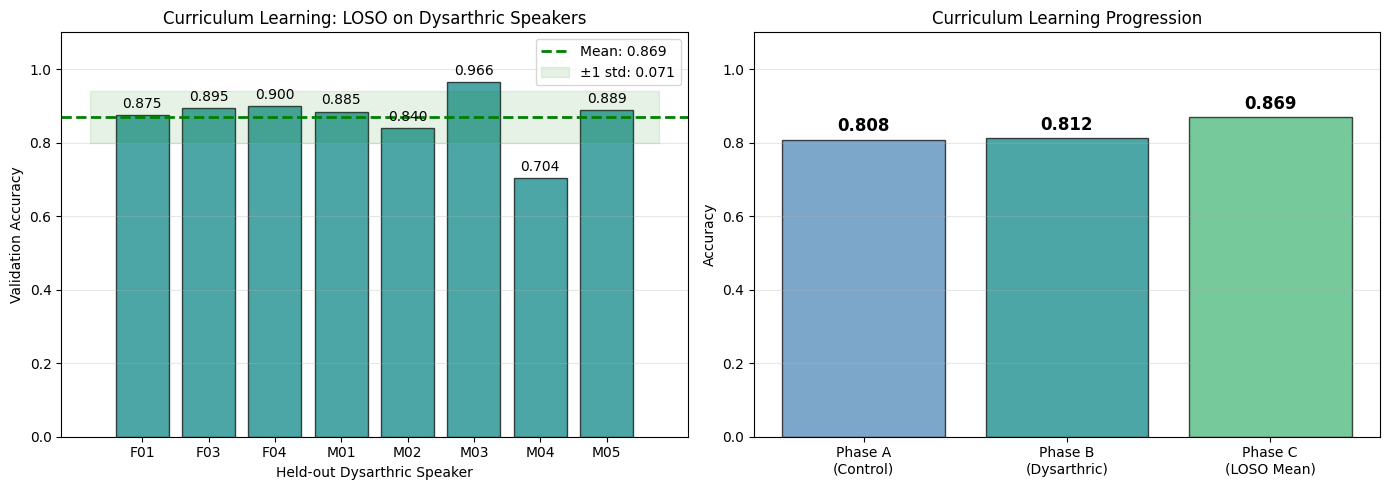

CV results saved to /root/autodl-tmp/dysarthric-voice-cmds/outputs/curriculum_cv_results.json


In [20]:
# =============================================================================
# VISUALIZE CURRICULUM LEARNING RESULTS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by fold (dysarthric speakers only)
ax1 = axes[0]
colors = ['teal' for _ in cv_summary['Val Speaker']]  # All dysarthric
bars = ax1.bar(cv_summary['Val Speaker'], cv_summary['Val Accuracy'], color=colors, alpha=0.7, edgecolor='black')

# Add accuracy labels on bars
for bar, acc in zip(bars, cv_summary['Val Accuracy']):
    ax1.annotate(f'{acc:.3f}', 
                 xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points',
                 ha='center', va='bottom', fontsize=10)

ax1.axhline(y=mean_acc, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_acc:.3f}')
ax1.fill_between(ax1.get_xlim(), mean_acc - std_acc, mean_acc + std_acc, 
                  color='green', alpha=0.1, label=f'±1 std: {std_acc:.3f}')
ax1.set_xlabel('Held-out Dysarthric Speaker')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Curriculum Learning: LOSO on Dysarthric Speakers')
ax1.set_ylim(0, 1.1)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Training progression through phases
ax2 = axes[1]
phases = ['Phase A\n(Control)', 'Phase B\n(Dysarthric)', 'Phase C\n(LOSO Mean)']
phase_accs = [best_train_acc_a, best_train_acc_b, mean_acc]
phase_colors = ['steelblue', 'teal', 'mediumseagreen']
bars2 = ax2.bar(phases, phase_accs, color=phase_colors, alpha=0.7, edgecolor='black')

for bar, acc in zip(bars2, phase_accs):
    ax2.annotate(f'{acc:.3f}', 
                 xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

ax2.set_ylabel('Accuracy')
ax2.set_title('Curriculum Learning Progression')
ax2.set_ylim(0, 1.1)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'curriculum_accuracy_by_fold.png', dpi=150, bbox_inches='tight')
plt.show()

# Save CV results to JSON
cv_results_json = {
    'mean_accuracy': float(mean_acc),
    'std_accuracy': float(std_acc),
    'fold_results': cv_summary.to_dict(orient='records'),
    'phase_a_accuracy': float(best_train_acc_a),
    'phase_b_accuracy': float(best_train_acc_b),
    'phase_c_mean_accuracy': float(mean_acc)
}
with open(config.OUTPUT_DIR / 'curriculum_cv_results.json', 'w') as f:
    json.dump(cv_results_json, f, indent=2)
print(f"CV results saved to {config.OUTPUT_DIR / 'curriculum_cv_results.json'}")

## 6. Model Evaluation

### Evaluation Metrics

1. **Overall Accuracy**: Simple metric, but can be misleading with class imbalance

2. **Per-Class Metrics** (from classification report):
   - **Precision**: Of predicted class X, how many were actually X?
   - **Recall**: Of actual class X, how many were predicted as X?
   - **F1-Score**: Harmonic mean of precision and recall

3. **Confusion Matrix**: Shows which classes are confused with each other
   - Useful for identifying acoustic similarities (e.g., "two" vs "to")

4. **Per-Speaker Accuracy**: Critical for assessing generalization
   - Dysarthric speakers may have lower accuracy (expected)
   - Control speakers should have higher accuracy
   - Large gaps may indicate model struggles with speech variability

### Why Per-Speaker Evaluation Matters
- Overall accuracy can hide poor performance on specific speakers
- Dysarthria severity varies significantly between individuals
- Real-world deployment requires consistent cross-speaker performance

In [21]:
# =============================================================================
# AGGREGATED CROSS-VALIDATION EVALUATION
# =============================================================================
# Use predictions from all folds (each sample predicted once when it was held out)

# Aggregate all predictions from CV
val_preds = cv_results['all_preds']
val_labels = cv_results['all_labels']
val_speakers = cv_results['all_speaker_ids']

# Calculate overall accuracy from aggregated predictions
overall_acc = accuracy_score(val_labels, val_preds)

print("="*60)
print("AGGREGATED CROSS-VALIDATION EVALUATION")
print("="*60)
print(f"\nTotal samples evaluated: {len(val_labels)}")
print(f"Overall Accuracy: {overall_acc:.4f} ({overall_acc*100:.2f}%)")
print(f"Correctly classified: {sum(p == l for p, l in zip(val_preds, val_labels))}/{len(val_labels)}")

AGGREGATED CROSS-VALIDATION EVALUATION

Total samples evaluated: 192
Overall Accuracy: 0.8698 (86.98%)
Correctly classified: 167/192


In [22]:
# Classification report
print("\nClassification Report:")
print("="*60)

# Get label names in order
label_names = [id2label[i] for i in range(len(id2label))]

# Only include labels that appear in the validation set
unique_labels = sorted(set(val_labels))
target_names = [id2label[i] for i in unique_labels]

print(classification_report(val_labels, val_preds, labels=unique_labels, target_names=target_names, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

        back       1.00      0.75      0.86         8
        down       0.89      0.80      0.84        10
       eight       1.00      0.80      0.89         5
        five       0.60      1.00      0.75         3
     forward       0.56      0.83      0.67         6
        four       0.75      0.75      0.75         8
        left       0.73      1.00      0.85        11
        menu       1.00      0.83      0.91         6
        nine       1.00      1.00      1.00         5
          no       0.96      1.00      0.98        22
         one       1.00      0.81      0.90        16
       right       0.92      1.00      0.96        11
      select       0.67      0.29      0.40         7
       seven       1.00      1.00      1.00         6
         six       1.00      1.00      1.00         5
       three       0.88      1.00      0.93         7
         two       0.92      0.58      0.71        19
   

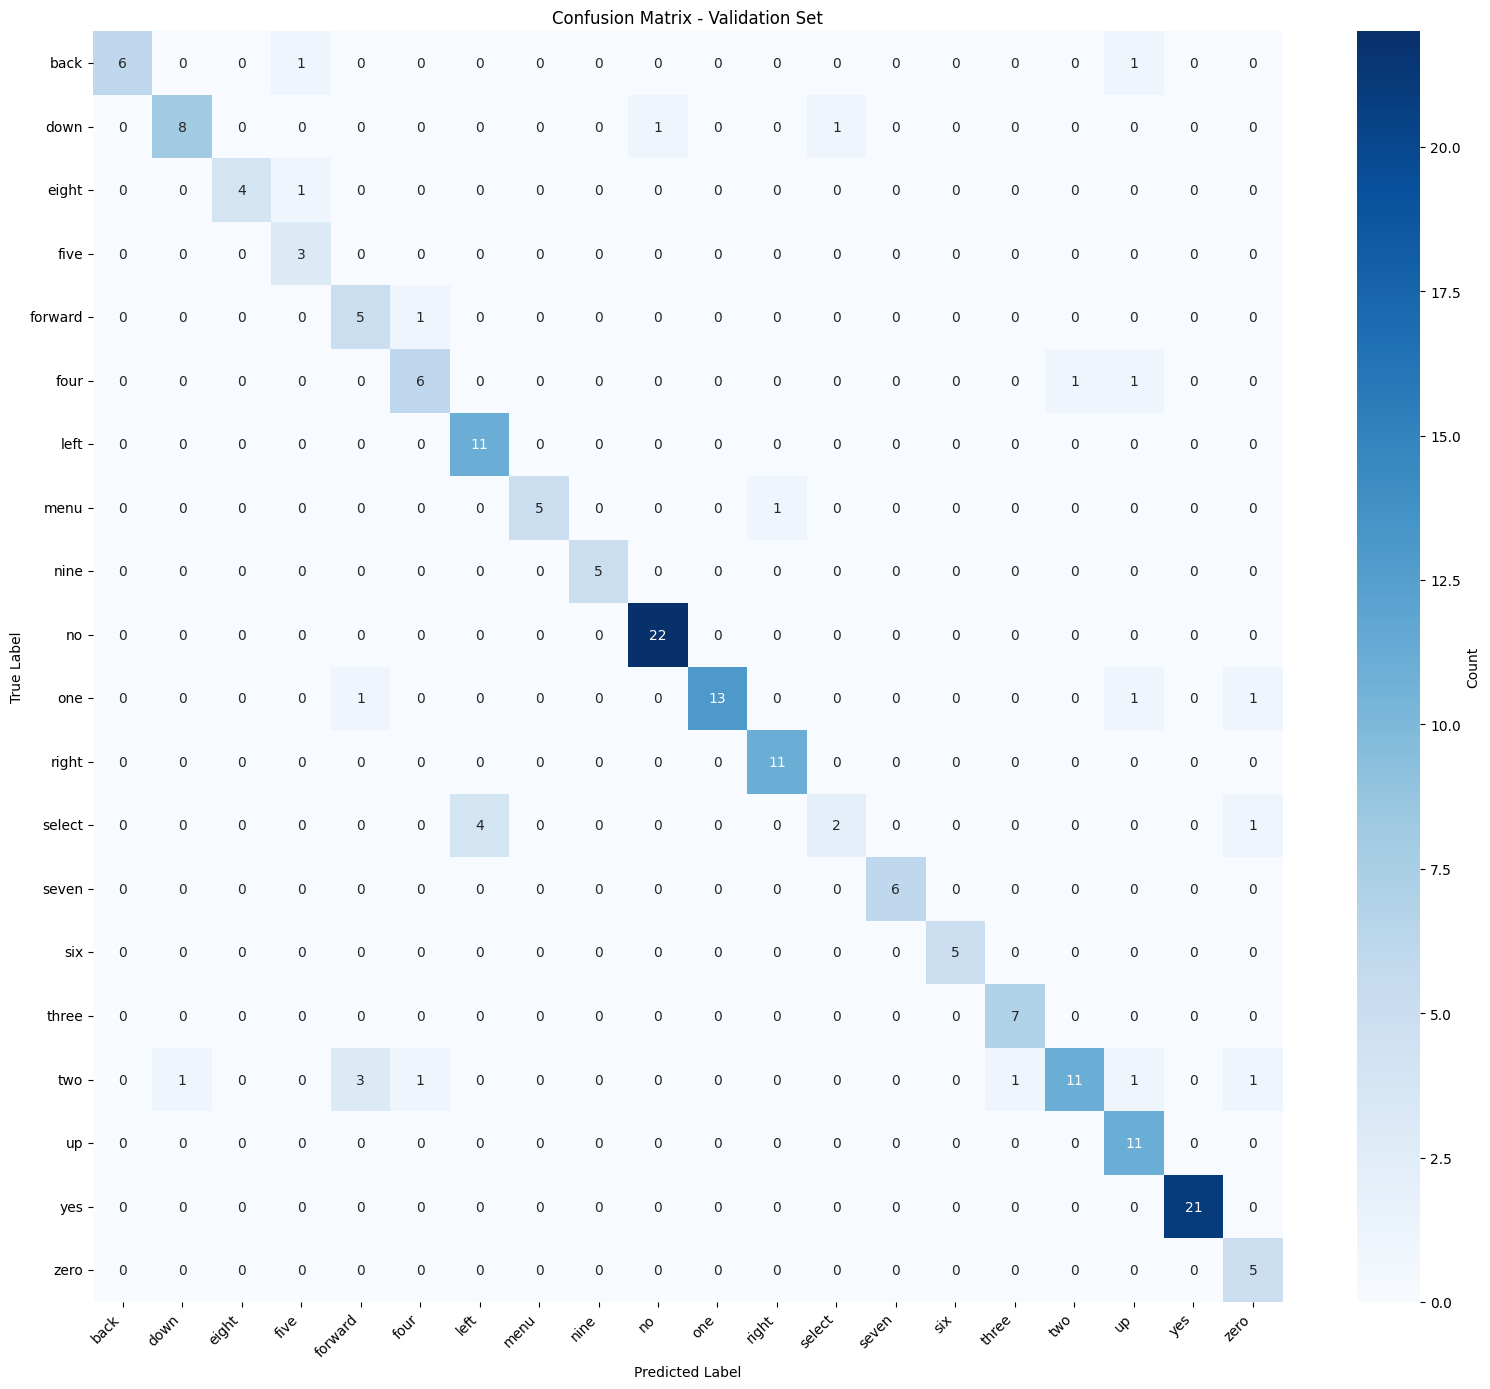

In [23]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds, labels=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


Per-Class Accuracy:
  back           : 0.7500 (8 samples)
  down           : 0.8000 (10 samples)
  eight          : 0.8000 (5 samples)
  five           : 1.0000 (3 samples)
  forward        : 0.8333 (6 samples)
  four           : 0.7500 (8 samples)
  left           : 1.0000 (11 samples)
  menu           : 0.8333 (6 samples)
  nine           : 1.0000 (5 samples)
  no             : 1.0000 (22 samples)
  one            : 0.8125 (16 samples)
  right          : 1.0000 (11 samples)
  select         : 0.2857 (7 samples)
  seven          : 1.0000 (6 samples)
  six            : 1.0000 (5 samples)
  three          : 1.0000 (7 samples)
  two            : 0.5789 (19 samples)
  up             : 1.0000 (11 samples)
  yes            : 1.0000 (21 samples)
  zero           : 1.0000 (5 samples)


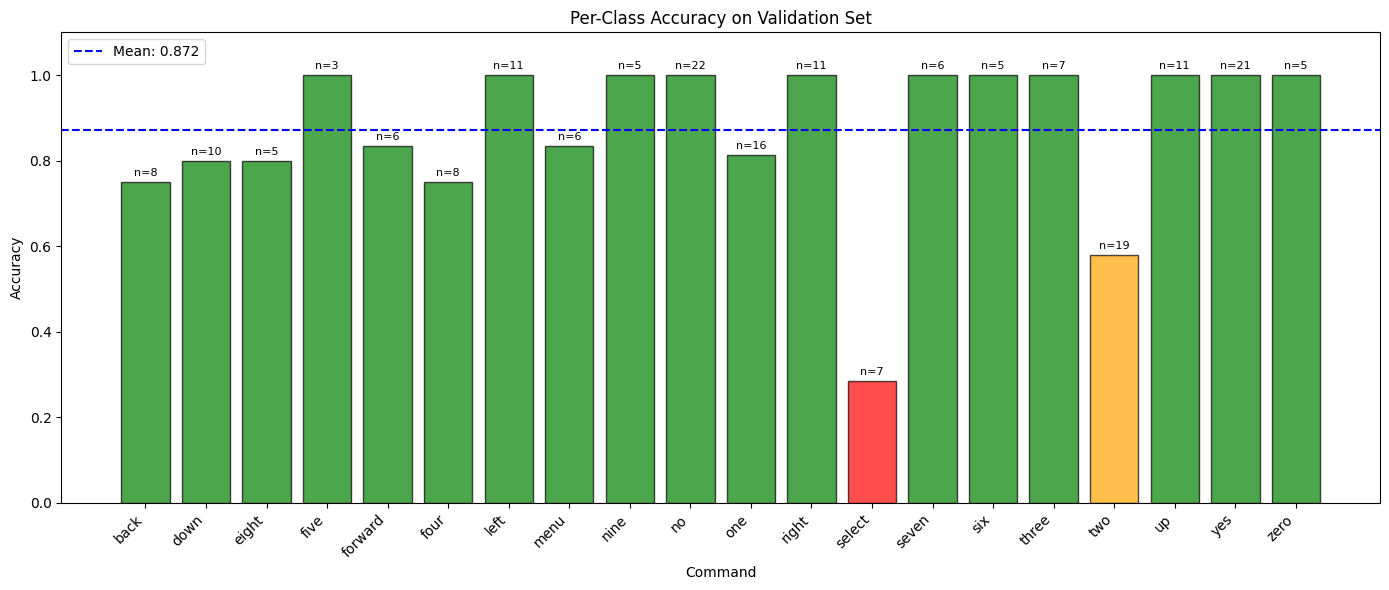

In [24]:
# Per-class accuracy analysis
print("\nPer-Class Accuracy:")
print("="*60)

per_class_acc = {}
for label_id in unique_labels:
    label_name = id2label[label_id]
    mask = np.array(val_labels) == label_id
    if mask.sum() > 0:
        acc = (np.array(val_preds)[mask] == label_id).mean()
        per_class_acc[label_name] = {'accuracy': acc, 'count': mask.sum()}
        print(f"  {label_name:15s}: {acc:.4f} ({mask.sum()} samples)")

# Plot per-class accuracy
plt.figure(figsize=(14, 6))
names = list(per_class_acc.keys())
accs = [per_class_acc[n]['accuracy'] for n in names]
counts = [per_class_acc[n]['count'] for n in names]

colors = ['green' if a >= 0.7 else 'orange' if a >= 0.5 else 'red' for a in accs]
bars = plt.bar(names, accs, color=colors, alpha=0.7, edgecolor='black')

# Add count annotations
for bar, count in zip(bars, counts):
    plt.annotate(f'n={count}', 
                 xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points',
                 ha='center', va='bottom', fontsize=8)

plt.axhline(y=np.mean(accs), color='blue', linestyle='--', label=f'Mean: {np.mean(accs):.3f}')
plt.xlabel('Command')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy on Validation Set')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()


Per-Speaker Accuracy (Dysarthric Speakers):
speaker_id  is_dysarthric  accuracy  correct  total
       F01           True  0.875000        7      8
       F03           True  0.894737       34     38
       F04           True  0.900000       27     30
       M01           True  0.884615       23     26
       M02           True  0.840000       21     25
       M03           True  0.965517       28     29
       M04           True  0.703704       19     27
       M05           True  0.888889        8      9


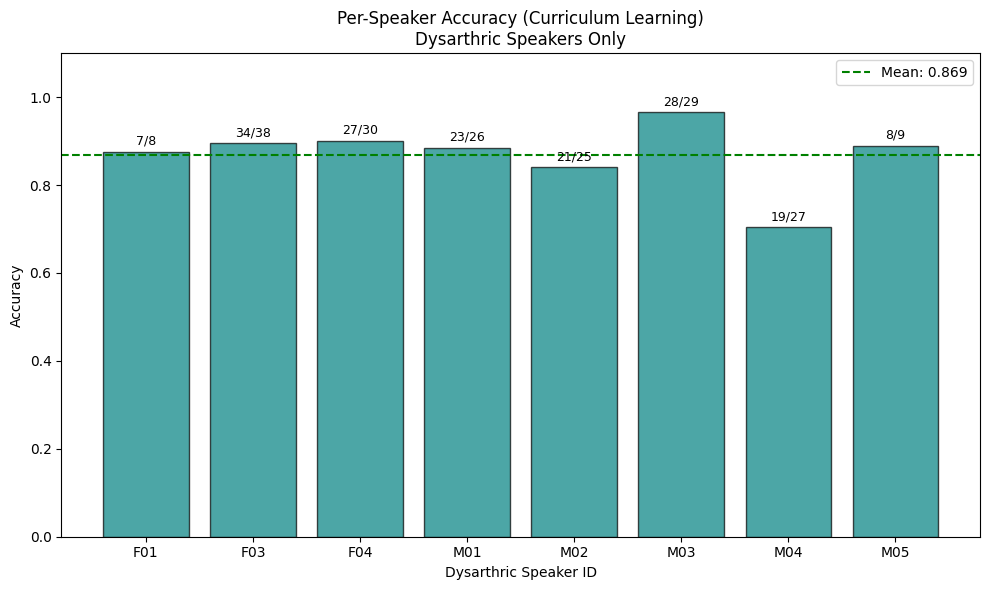


Summary:
  Mean accuracy across dysarthric speakers: 0.8691
  Std accuracy: 0.0754


In [25]:
# Per-speaker accuracy analysis (dysarthric speakers only)
print("\nPer-Speaker Accuracy (Dysarthric Speakers):")
print("="*60)

# Create DataFrame for analysis
results_df = pd.DataFrame({
    'speaker_id': val_speakers,
    'true_label': val_labels,
    'pred_label': val_preds,
    'correct': [t == p for t, p in zip(val_labels, val_preds)]
})

# Get speaker info from dysarthric dataframe
speaker_info = dysarthric_df[['speaker_id', 'is_dysarthric']].drop_duplicates()
results_df = results_df.merge(speaker_info, on='speaker_id', how='left')

# Calculate per-speaker accuracy
speaker_acc = results_df.groupby(['speaker_id', 'is_dysarthric']).agg({
    'correct': ['mean', 'sum', 'count']
}).reset_index()
speaker_acc.columns = ['speaker_id', 'is_dysarthric', 'accuracy', 'correct', 'total']

print(speaker_acc.to_string(index=False))

# Plot per-speaker accuracy
plt.figure(figsize=(10, 6))
colors = ['teal' for _ in speaker_acc['is_dysarthric']]  # All dysarthric
bars = plt.bar(speaker_acc['speaker_id'], speaker_acc['accuracy'], color=colors, alpha=0.7, edgecolor='black')

# Add count annotations
for bar, (_, row) in zip(bars, speaker_acc.iterrows()):
    plt.annotate(f'{int(row["correct"])}/{int(row["total"])}', 
                 xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points',
                 ha='center', va='bottom', fontsize=9)

plt.axhline(y=speaker_acc['accuracy'].mean(), color='green', linestyle='--', 
            label=f'Mean: {speaker_acc["accuracy"].mean():.3f}')
plt.xlabel('Dysarthric Speaker ID')
plt.ylabel('Accuracy')
plt.title('Per-Speaker Accuracy (Curriculum Learning)\nDysarthric Speakers Only')
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'curriculum_per_speaker_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
print("\n" + "="*60)
print("Summary:")
print(f"  Mean accuracy across dysarthric speakers: {speaker_acc['accuracy'].mean():.4f}")
print(f"  Std accuracy: {speaker_acc['accuracy'].std():.4f}")

In [26]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("\n" + "="*60)
print("CURRICULUM LEARNING TRAINING COMPLETE")
print("="*60)

print(f"\nModel: HuBERT-large + MLP Classification Head")
print(f"Task: {len(label2id)}-class dysarthric voice command classification")
print(f"Dataset: TORGO ({len(df)} samples from {len(all_speakers)} speakers)")

print(f"\nCurriculum Learning Strategy:")
print(f"  Phase A: Control pretraining ({config.CURRICULUM_CONTROL_EPOCHS} epochs on {len(control_speakers)} speakers)")
print(f"  Phase B: Dysarthric fine-tuning ({config.CURRICULUM_DYSARTHRIC_EPOCHS} epochs on {len(dysarthric_speakers)} speakers)")
print(f"  Phase C: LOSO evaluation ({len(dysarthric_speakers)} folds, {LOSO_FINETUNE_EPOCHS} epochs each)")

print(f"\nTraining Configuration:")
print(f"  Unfreeze layers: {config.CURRICULUM_UNFREEZE_LAYERS}")
print(f"  Class weighting: {'Enabled' if config.USE_CLASS_WEIGHTS else 'Disabled'}")

print(f"\nData Augmentation:")
print(f"  audiomentations: Noise, Pitch, TimeStretch, Shift, Gain")
print(f"  SpecAugment: Time masking")

print(f"\nResults:")
print(f"  Phase A (Control) Training Accuracy: {best_train_acc_a:.4f}")
print(f"  Phase B (Dysarthric) Training Accuracy: {best_train_acc_b:.4f}")
print(f"  Phase C (LOSO) Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"  Aggregated Accuracy: {overall_acc:.4f}")

print(f"\nSaved Outputs:")
print(f"  Phase A checkpoint: {config.OUTPUT_DIR / 'phase_a_control_pretrained.pt'}")
print(f"  Phase B checkpoint: {config.OUTPUT_DIR / 'phase_b_curriculum_trained.pt'}")
print(f"  Fold models: {config.OUTPUT_DIR}/curriculum_fold*_*.pt")
print(f"  CV results: {config.OUTPUT_DIR / 'curriculum_cv_results.csv'}")
print(f"  CV visualization: {config.OUTPUT_DIR / 'curriculum_accuracy_by_fold.png'}")
print(f"  Confusion matrix: {config.OUTPUT_DIR / 'confusion_matrix.png'}")
print(f"  Per-class accuracy: {config.OUTPUT_DIR / 'per_class_accuracy.png'}")
print(f"  Per-speaker accuracy: {config.OUTPUT_DIR / 'curriculum_per_speaker_accuracy.png'}")


CURRICULUM LEARNING TRAINING COMPLETE

Model: HuBERT-large + MLP Classification Head
Task: 20-class dysarthric voice command classification
Dataset: TORGO (562 samples from 15 speakers)

Curriculum Learning Strategy:
  Phase A: Control pretraining (15 epochs on 7 speakers)
  Phase B: Dysarthric fine-tuning (15 epochs on 8 speakers)
  Phase C: LOSO evaluation (8 folds, 10 epochs each)

Training Configuration:
  Unfreeze layers: 4
  Class weighting: Enabled

Data Augmentation:
  audiomentations: Noise, Pitch, TimeStretch, Shift, Gain
  SpecAugment: Time masking

Results:
  Phase A (Control) Training Accuracy: 0.8081
  Phase B (Dysarthric) Training Accuracy: 0.8125
  Phase C (LOSO) Mean Accuracy: 0.8691 ± 0.0705
  Aggregated Accuracy: 0.8698

Saved Outputs:
  Phase A checkpoint: /root/autodl-tmp/dysarthric-voice-cmds/outputs/phase_a_control_pretrained.pt
  Phase B checkpoint: /root/autodl-tmp/dysarthric-voice-cmds/outputs/phase_b_curriculum_trained.pt
  Fold models: /root/autodl-tmp/dysa